# Определение стоимости автомобилей

__Описание исследования__

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.

__Цель исследования__

Нужно построить модель для определения стоимости автомобиля на основе имеющихся данных.
Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

В качестве метрики моделей выбрана RMSE, она не должна быть больше 2500.

__Задачи исследования__

Необходимо загрузить данные, выполнить их предобработку: анализ типов данных, заполнение или устранение пропусков, поиск дубликатов. Затем провести исследовательский анализ с целью выявления закономерностей в данных, а также выявления аномалий и выбросов. Провести корреляционный анализ. Затем, осуществить обучение нескольких моделей регрессии, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробовать подобрать разные гиперпараметры.
Проанализировать время обучения, время предсказания и качество моделей. Опираясь на критерии заказчика, выбрать лучшую модель, проверить её качество на тестовой выборке.


__Исходные данные__

В нашем датасете присутсвуют следующие признаки:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:
- Price — цена (евро)

In [1]:
#Устанавливаем необходимые компоненты
!pip install phik -q
!pip install wordcloud -q
!pip install --upgrade scikit-learn -q
!pip install lightgbm -q
!pip install catboost -q

In [2]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import os
import math
from time import time

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_squared_error, root_mean_squared_error

In [3]:
RANDOM_STATE = 29
TEST_SIZE = 0.3
TEST_SIZE_TT = 0.4
TEST_SIZE_VT = 0.5

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None
sns.set_theme(style='darkgrid')
pd.set_option('display.float_format', '{:,.3f}'.format)

## Загрузка и подготовка данных

### Загрузка и предварительный просмотр

In [4]:
# Загружаем данные из файлов в датафремы
pth_local = (r'datasets\autos.csv')
pth_cloud = ('/datasets/autos.csv')

# Проверяем наличие файла по набранному пути
if os.path.exists(pth_local) :
    # Считываем файл, задаем разделитель и переводим даты в нужный формат
    df = pd.read_csv(pth_local, sep=',', parse_dates=['DateCrawled','DateCreated','LastSeen'])
elif os.path.exists(pth_cloud):
    df = pd.read_csv(pth_cloud, sep=',', parse_dates=['DateCrawled','DateCreated','LastSeen'])
else:
    print('Проверьте правильность написания пути к файлам или их доступность по указанному адресу')

In [5]:
# Отображение информации по df, первые строки, типы данных, размер
display(df.head())
print('\n\033[1mИнформация по составу датафрейма:\033[0m\n')
df.info()
print('\n\n\n')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21



Информация по составу датафрейма:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOf

In [6]:
# Функция, которая выдает количество строк и столбцов
def df_size(df):
    print(f'Размер датафрейма: строк - {df.shape[0]}, столбцов - {df.shape[1]}')

### Проверка названий и изменение типов данных

In [7]:
df_size(df)

Размер датафрейма: строк - 354369, столбцов - 16


In [8]:
display(df.columns)

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

Названия столбцов не требуют корректировок и представлены в удобном формате.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

Даты мы перевели в нужный формат при загрузке в датафрейм, остальные столбцы преобразований не требуют. Названия в датафрейме представлены в стиле CamelCase, корректировки не требуют.

### Обработка пропусков 

In [10]:
# Пишем функцию для отсображения кол-ва, процента пропущенных значений и типа данных
def numb_isna(df, plot):
    isna_types = pd.concat([df.isna().sum(),(df.isna().sum() / df.isna().count() * 100).round(2),
                            df.dtypes],axis=1)
    isna_types.columns = ['sum_isna','percent_isna','value_type']
    isna_types.sort_values(by='sum_isna', ascending=False)

    if plot:
        # Строим тепловую карту
        colors = ['#000000', '#40E0D0'] # определяем цвета, бирюзовый - пропущенные данные, черный - не пропущенные
        fig = plt.subplots(figsize=(18, 6))
        sns.heatmap(df.isna(),cmap=sns.color_palette(colors),cbar= False)
    
        plt.title('Тепловая карта пропусков', fontsize = 14)
        plt.xlabel('Название столбца', fontsize = 12)
        plt.ylabel('Кол-во пропусков', fontsize = 12)
        plt.xticks(rotation=15)
        plt.show();
    
    return isna_types

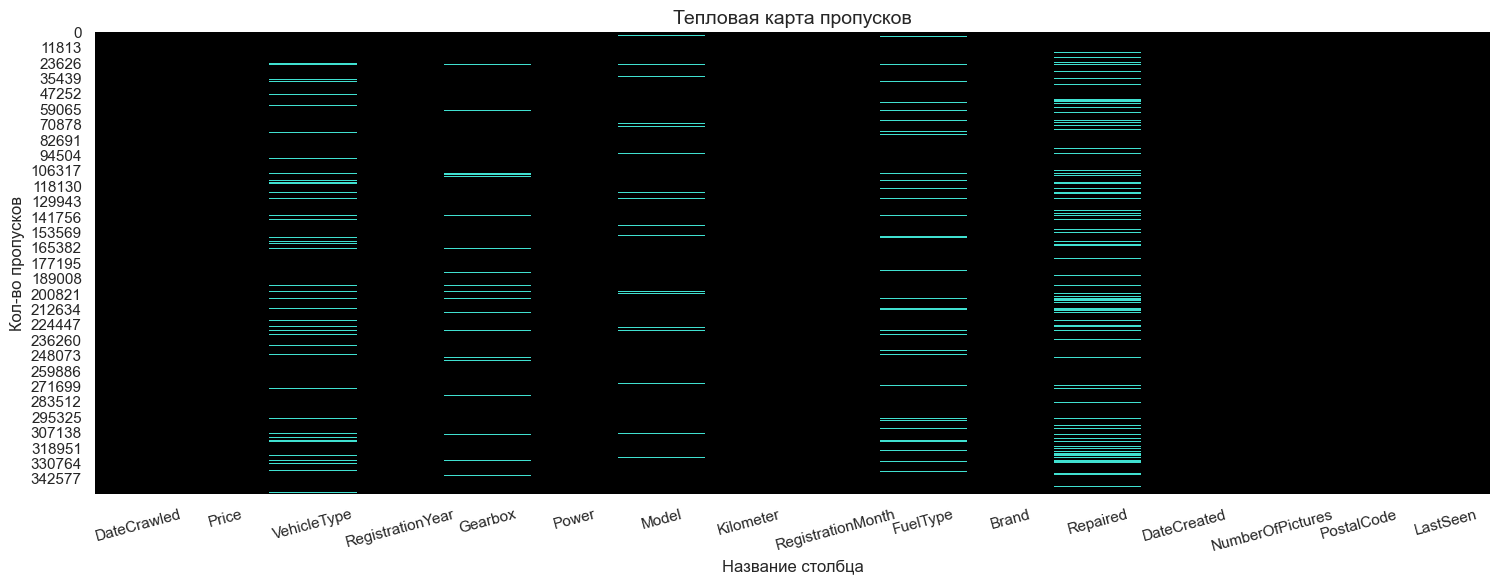

,sum_isna,percent_isna,value_type
DateCrawled,0,0.000,datetime64[ns]
Price,0,0.000,int64
VehicleType,37490,10.580,object
RegistrationYear,0,0.000,int64
Gearbox,19833,5.600,object
Power,0,0.000,int64
Model,19705,5.560,object
Kilometer,0,0.000,int64
RegistrationMonth,0,0.000,int64
FuelType,32895,9.280,object


In [11]:
display(numb_isna(df,True))
print('\n\n')

In [12]:
def nan_plus_uniq_val(df,col):
    # Смотрим на пропущенные значения
    print('\033[1mЗаписи с пропущенными данными:\033[0m')
    display(df[df[col].isna()].head(10))
    print('\033[1mУникальные значения в столбце:\033[0m')
    # Анализируем уникальные значения и их частоту присутсвия
    display(df[col].value_counts())

Видим, что присутвует достаточно большое количество пропущенных значений в датафрейме.Начнем разбирать пропуски и с чем они могут быть связаны.

In [13]:
df.query('VehicleType.isna() and Gearbox.isna() and Model.isna() and FuelType.isna() and Repaired.isna()').count()

DateCrawled          2237
Price                2237
VehicleType             0
RegistrationYear     2237
Gearbox                 0
Power                2237
Model                   0
Kilometer            2237
RegistrationMonth    2237
FuelType                0
Brand                2237
Repaired                0
DateCreated          2237
NumberOfPictures     2237
PostalCode           2237
LastSeen             2237
dtype: int64

In [14]:
df_size(df)

Размер датафрейма: строк - 354369, столбцов - 16


- __VehicleType__

In [15]:
nan_plus_uniq_val(df, 'VehicleType')

Записи с пропущенными данными:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
16,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01,0,38871,2016-04-01 12:46:46
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23,0,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10,0,31139,2016-03-16 09:16:46
31,2016-03-29 16:57:02,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29,0,37075,2016-03-29 17:43:07
35,2016-03-08 07:54:46,350,NaN,2016,manual,75,golf,150000,4,petrol,volkswagen,no,2016-03-08,0,19386,2016-03-08 09:44:50
37,2016-03-28 17:50:15,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28,0,46483,2016-03-30 09:18:02
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26,0,56412,2016-03-27 17:43:34
48,2016-03-25 14:40:12,7750,NaN,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN,2016-03-25,0,48499,2016-03-31 21:47:44
51,2016-03-07 18:57:08,2000,NaN,2017,manual,90,punto,150000,11,gasoline,fiat,yes,2016-03-07,0,66115,2016-03-07 18:57:08


Уникальные значения в столбце:


VehicleType
sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: count, dtype: int64

Заполним в этом столбце пропущенные значения на "other", созадавать новую колонку особо смысла не видно.

In [16]:
df['VehicleType'] = df['VehicleType'].fillna('other')

- __Gearbox__ и __Model__

In [17]:
nan_plus_uniq_val(df, 'Gearbox')

Записи с пропущенными данными:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11,0,24148,2016-03-19 08:46:47
16,2016-04-01 12:46:46,300,other,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01,0,38871,2016-04-01 12:46:46
32,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15,0,44145,2016-03-17 18:17:43
37,2016-03-28 17:50:15,1500,other,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28,0,46483,2016-03-30 09:18:02
40,2016-03-26 22:06:17,0,other,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26,0,56412,2016-03-27 17:43:34
69,2016-04-01 11:56:40,1200,coupe,2001,NaN,0,astra,150000,0,NaN,opel,NaN,2016-04-01,0,47249,2016-04-07 08:46:07
92,2016-03-16 07:56:19,250,other,2000,NaN,60,ka,150000,0,NaN,ford,NaN,2016-03-16,0,51427,2016-03-21 09:47:08
94,2016-03-28 16:37:43,8390,other,2009,NaN,0,insignia,150000,0,NaN,opel,NaN,2016-03-28,0,29221,2016-03-30 07:44:59
110,2016-04-03 03:57:26,350,small,1998,NaN,0,corsa,150000,2,petrol,opel,NaN,2016-04-03,0,82110,2016-04-03 08:53:37
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20,0,37520,2016-04-07 02:45:22


Уникальные значения в столбце:


Gearbox
manual    268251
auto       66285
Name: count, dtype: int64

Создадим новую группу и заполним в этом столбце пропущенные значения на "unknown".

In [18]:
nan_plus_uniq_val(df, 'Model')

Записи с пропущенными данными:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
59,2016-03-29 15:48:15,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29,0,53721,2016-04-06 01:44:38
81,2016-04-03 12:56:45,350,small,1997,manual,54,NaN,150000,3,NaN,fiat,yes,2016-04-03,0,45665,2016-04-05 11:47:13
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20,0,37520,2016-04-07 02:45:22
135,2016-03-27 20:51:23,1450,sedan,1992,manual,136,NaN,150000,0,NaN,audi,no,2016-03-27,0,38709,2016-04-05 20:17:31
151,2016-03-27 20:47:22,6799,small,2009,NaN,60,NaN,20000,5,petrol,volkswagen,no,2016-03-27,0,89077,2016-03-27 20:47:22
160,2016-03-19 19:49:15,500,small,1999,manual,0,NaN,150000,0,petrol,renault,no,2016-03-19,0,26969,2016-04-01 11:17:48
161,2016-03-28 10:50:04,1495,wagon,2001,NaN,64,NaN,150000,9,gasoline,volkswagen,NaN,2016-03-28,0,99086,2016-04-04 11:45:46
186,2016-03-16 15:51:08,14000,sedan,2008,NaN,235,NaN,150000,0,NaN,bmw,no,2016-02-12,0,95131,2016-04-07 14:56:12
193,2016-03-27 12:47:45,1200,coupe,1990,manual,45,NaN,150000,0,petrol,volkswagen,NaN,2016-03-27,0,83317,2016-04-07 08:17:08


Уникальные значения в столбце:


Model
golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: count, Length: 250, dtype: int64

Возможности восстановить пропущенные значения по имеющимся данным нет, заменим пропущенные значения в поле по типу передачи на "unknown", а в поле модели автомобиля причислим неизвестные марки к категории "other".

In [19]:
df['Gearbox'] = df['Gearbox'].fillna('unknown')
df['Model'] = df['Model'].fillna('other')

- __FuelType__

In [20]:
nan_plus_uniq_val(df, 'FuelType')

Записи с пропущенными данными:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17,0,27472,2016-03-31 17:17:06
13,2016-03-21 21:37:40,2500,wagon,2004,manual,131,passat,150000,2,NaN,volkswagen,no,2016-03-21,0,90762,2016-03-23 02:50:54
26,2016-03-10 19:38:18,5555,other,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10,0,31139,2016-03-16 09:16:46
36,2016-03-11 11:50:37,1600,other,1991,manual,75,kadett,70000,0,NaN,opel,NaN,2016-03-11,0,2943,2016-04-07 03:46:09
41,2016-03-30 20:38:20,7500,sedan,2002,auto,306,e_klasse,150000,4,NaN,mercedes_benz,NaN,2016-03-30,0,33649,2016-04-03 11:44:49
52,2016-04-04 10:57:36,1400,other,2016,manual,55,other,5000,1,NaN,hyundai,NaN,2016-04-04,0,34454,2016-04-06 12:45:43
54,2016-03-17 07:56:40,4700,wagon,2005,manual,0,signum,150000,0,NaN,opel,no,2016-03-17,0,88433,2016-04-04 04:17:32
57,2016-03-10 20:53:19,2399,other,2018,manual,64,other,125000,3,NaN,seat,no,2016-03-10,0,33397,2016-03-25 10:17:37
59,2016-03-29 15:48:15,1,suv,1994,manual,286,other,150000,11,NaN,sonstige_autos,NaN,2016-03-29,0,53721,2016-04-06 01:44:38
65,2016-03-28 17:41:27,10900,other,2017,manual,101,astra,50000,3,NaN,opel,no,2016-03-28,0,63607,2016-04-06 23:15:52


Уникальные значения в столбце:


FuelType
petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: count, dtype: int64

Причислим записи с NaN значением по виду топлива к категории "other".

In [21]:
df['FuelType'] = df['FuelType'].fillna('other')

- __Repaired__

In [22]:
nan_plus_uniq_val(df, 'Repaired')

Записи с пропущенными данными:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,other,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,other,volkswagen,NaN,2016-03-17,0,27472,2016-03-31 17:17:06
12,2016-03-15 22:49:09,999,wagon,1995,manual,115,passat,150000,11,petrol,volkswagen,NaN,2016-03-15,0,37269,2016-04-01 13:16:16
15,2016-03-11 21:39:15,450,small,1910,unknown,0,ka,5000,0,petrol,ford,NaN,2016-03-11,0,24148,2016-03-19 08:46:47
16,2016-04-01 12:46:46,300,other,2016,unknown,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01,0,38871,2016-04-01 12:46:46
31,2016-03-29 16:57:02,899,other,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29,0,37075,2016-03-29 17:43:07
36,2016-03-11 11:50:37,1600,other,1991,manual,75,kadett,70000,0,other,opel,NaN,2016-03-11,0,2943,2016-04-07 03:46:09
40,2016-03-26 22:06:17,0,other,1990,unknown,0,corsa,150000,1,petrol,opel,NaN,2016-03-26,0,56412,2016-03-27 17:43:34


Уникальные значения в столбце:


Repaired
no     247161
yes     36054
Name: count, dtype: int64

Также заменим неизвестные значения на "unknown".

In [23]:
df['Repaired'] = df['Repaired'].fillna('unknown')

In [24]:
df_size(df)

Размер датафрейма: строк - 354369, столбцов - 16


### Поиск и обработка дубликатов

In [25]:
# Смотрим наличие дубликатов в датафреймах
print(f'Количество явных дубликатов до обработки: {df.duplicated().sum()}')
display(df[df.duplicated()])
print('-' * 120)

Количество явных дубликатов до обработки: 4


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15


------------------------------------------------------------------------------------------------------------------------


Оставим только первые записи из дублированных, остальные удалим.

In [26]:
df = df.drop_duplicates(keep='first').reset_index(drop=True)

In [27]:
df_size(df)

Размер датафрейма: строк - 354365, столбцов - 16


In [28]:
# Смотрим уникальные значения по столбцам датафреймов, 
# С целью выявления неявных дубликатов и ошибок, возможных при вводе данных
for col in df.columns:
    print(f'{df[col].name}:\n {df[col].unique()}\n')
    print(f'Количество уникальных значений в поле: \033[1m{df[col].nunique()}\033[0m')
    print('_ _ ' * 50)
print('\033[1m____\033[0m' * 50)

DateCrawled:
 <DatetimeArray>
['2016-03-24 11:52:17', '2016-03-24 10:58:45', '2016-03-14 12:52:21',
 '2016-03-17 16:54:04', '2016-03-31 17:25:20', '2016-04-04 17:36:23',
 '2016-04-01 20:48:51', '2016-03-21 18:54:38', '2016-04-04 23:42:13',
 '2016-03-17 10:53:50',
 ...
 '2016-03-16 17:06:19', '2016-04-02 16:43:27', '2016-03-06 21:11:23',
 '2016-04-04 11:45:16', '2016-04-04 09:57:12', '2016-03-09 13:37:43',
 '2016-03-19 19:53:49', '2016-03-21 09:50:58', '2016-03-14 17:48:27',
 '2016-03-19 18:57:12']
Length: 271174, dtype: datetime64[ns]

Количество уникальных значений в поле: 271174
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Price:
 [  480 18300  9800 ... 12395 18429 10985]

Количество уникальных значений в поле: 3731
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

Особых проблем в данных не видно, задублированных значений в категориях не обнаружено. Можно подумать о том, какие признаки нам будут полезны, а какие не принесут модели никакой пользы.

Удалим из данных признаки, которые, как кажется, не помогут в определении стоимости автомобиля:
- DateCrawled — дата скачивания анкеты из базы.
- DateCreated — дата создания анкеты.
- PostalCode — почтовый индекс владельца анкеты (пользователя).
- NumberOfPictures — количество фотографий автомобиля.
- LastSeen — дата последней активности пользователя.

In [29]:
df['DateCrawled'].max()

Timestamp('2016-04-07 14:36:58')

In [30]:
df = df.drop(['DateCrawled','DateCreated','PostalCode','NumberOfPictures','LastSeen'], axis=1)

In [31]:
# Смотрим наличие дубликатов в датафреймах
print(f'Количество явных дубликатов до обработки: {df.duplicated().sum()}')
display(df[df.duplicated()])
print('-' * 120)

Количество явных дубликатов до обработки: 27646


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
1396,0,other,2000,unknown,0,other,150000,0,other,volvo,unknown
3025,2800,wagon,2005,unknown,0,touran,150000,11,gasoline,volkswagen,no
3458,300,small,2000,manual,54,corsa,150000,0,petrol,opel,unknown
3551,1670,sedan,1999,manual,75,golf,150000,8,petrol,volkswagen,no
3786,2999,sedan,2002,manual,101,golf,150000,6,gasoline,volkswagen,no
...,...,...,...,...,...,...,...,...,...,...,...
354332,3299,other,2005,auto,0,outlander,150000,4,petrol,mitsubishi,unknown
354333,11500,sedan,2004,auto,445,7er,125000,0,petrol,bmw,unknown
354348,6500,sedan,2003,auto,145,e_klasse,150000,3,gasoline,mercedes_benz,no
354351,4400,sedan,2008,manual,105,leon,150000,7,gasoline,seat,no


------------------------------------------------------------------------------------------------------------------------


После удаления лишних признаков, появились новые явные дубликаты в данных, так как такие данные для модели не несут положительной нагрузки, удалим дубликаты.

In [32]:
df = df.drop_duplicates(keep='first').reset_index(drop=True)

In [33]:
df_size(df)

Размер датафрейма: строк - 326719, столбцов - 11


### Исследовательский анализ данных

In [34]:
df.head(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,other,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


In [35]:
# Смотрим описательные характеристики
display(df.describe())

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,"326,719.000","326,719.000","326,719.000","326,719.000","326,719.000"
mean,"4,404.326","2,004.232",110.259,"128,147.552",5.697
std,"4,518.370",91.135,195.913,"37,942.469",3.724
min,0.000,"1,000.000",0.000,"5,000.000",0.000
25%,"1,000.000","1,999.000",69.000,"125,000.000",3.000
50%,"2,700.000","2,003.000",105.000,"150,000.000",6.000
75%,"6,350.000","2,008.000",141.000,"150,000.000",9.000
max,"20,000.000","9,999.000","20,000.000","150,000.000",12.000


Видим, что присутсвует большая разница между медианами и средними значениями в данных по цене автомобилей, менее высокие расхождения по году регистрации, мощности, пробегу и  месяцу регистрации, а также наличие выбросов в датафреймах. Перейдем к подробной оценке количественных значений, с визуализацией распределения значений.

In [36]:
# функция для построения гистограммы и диаграммы распределения значений
def plot_hist_box(df,columns,subplots,figsize,bins,title_h,title_b,y_h,x_h,y_b,x_b):

    display(df.describe())
    
    fig, axs = plt.subplots(subplots, 1, figsize=figsize)
    
    j = 0
    i = 0
    for col in columns:
        # определение параметров построения гисторграммы
        sns.histplot(data=df[col], ax=axs[i],bins=bins[j], fill=True)#kde=True)
        axs[i].set_title(title_h[j],fontsize=12)
        axs[i].set_ylabel(y_h[j])
        axs[i].set_xlabel(x_h[j])

        # определение параметров построения boxplot
        i += 1  
        sns.boxplot(x=df[col],showmeans=True, ax=axs[i])
        axs[i].set_title(title_b[j],fontsize=12)
        axs[i].set_ylabel(y_b[j])
        axs[i].set_xlabel(x_b[j])
        
        plt.tight_layout()
        
        if i < subplots:
            i += 1
            j += 1

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,"326,719.000","326,719.000","326,719.000","326,719.000","326,719.000"
mean,"4,404.326","2,004.232",110.259,"128,147.552",5.697
std,"4,518.370",91.135,195.913,"37,942.469",3.724
min,0.000,"1,000.000",0.000,"5,000.000",0.000
25%,"1,000.000","1,999.000",69.000,"125,000.000",3.000
50%,"2,700.000","2,003.000",105.000,"150,000.000",6.000
75%,"6,350.000","2,008.000",141.000,"150,000.000",9.000
max,"20,000.000","9,999.000","20,000.000","150,000.000",12.000


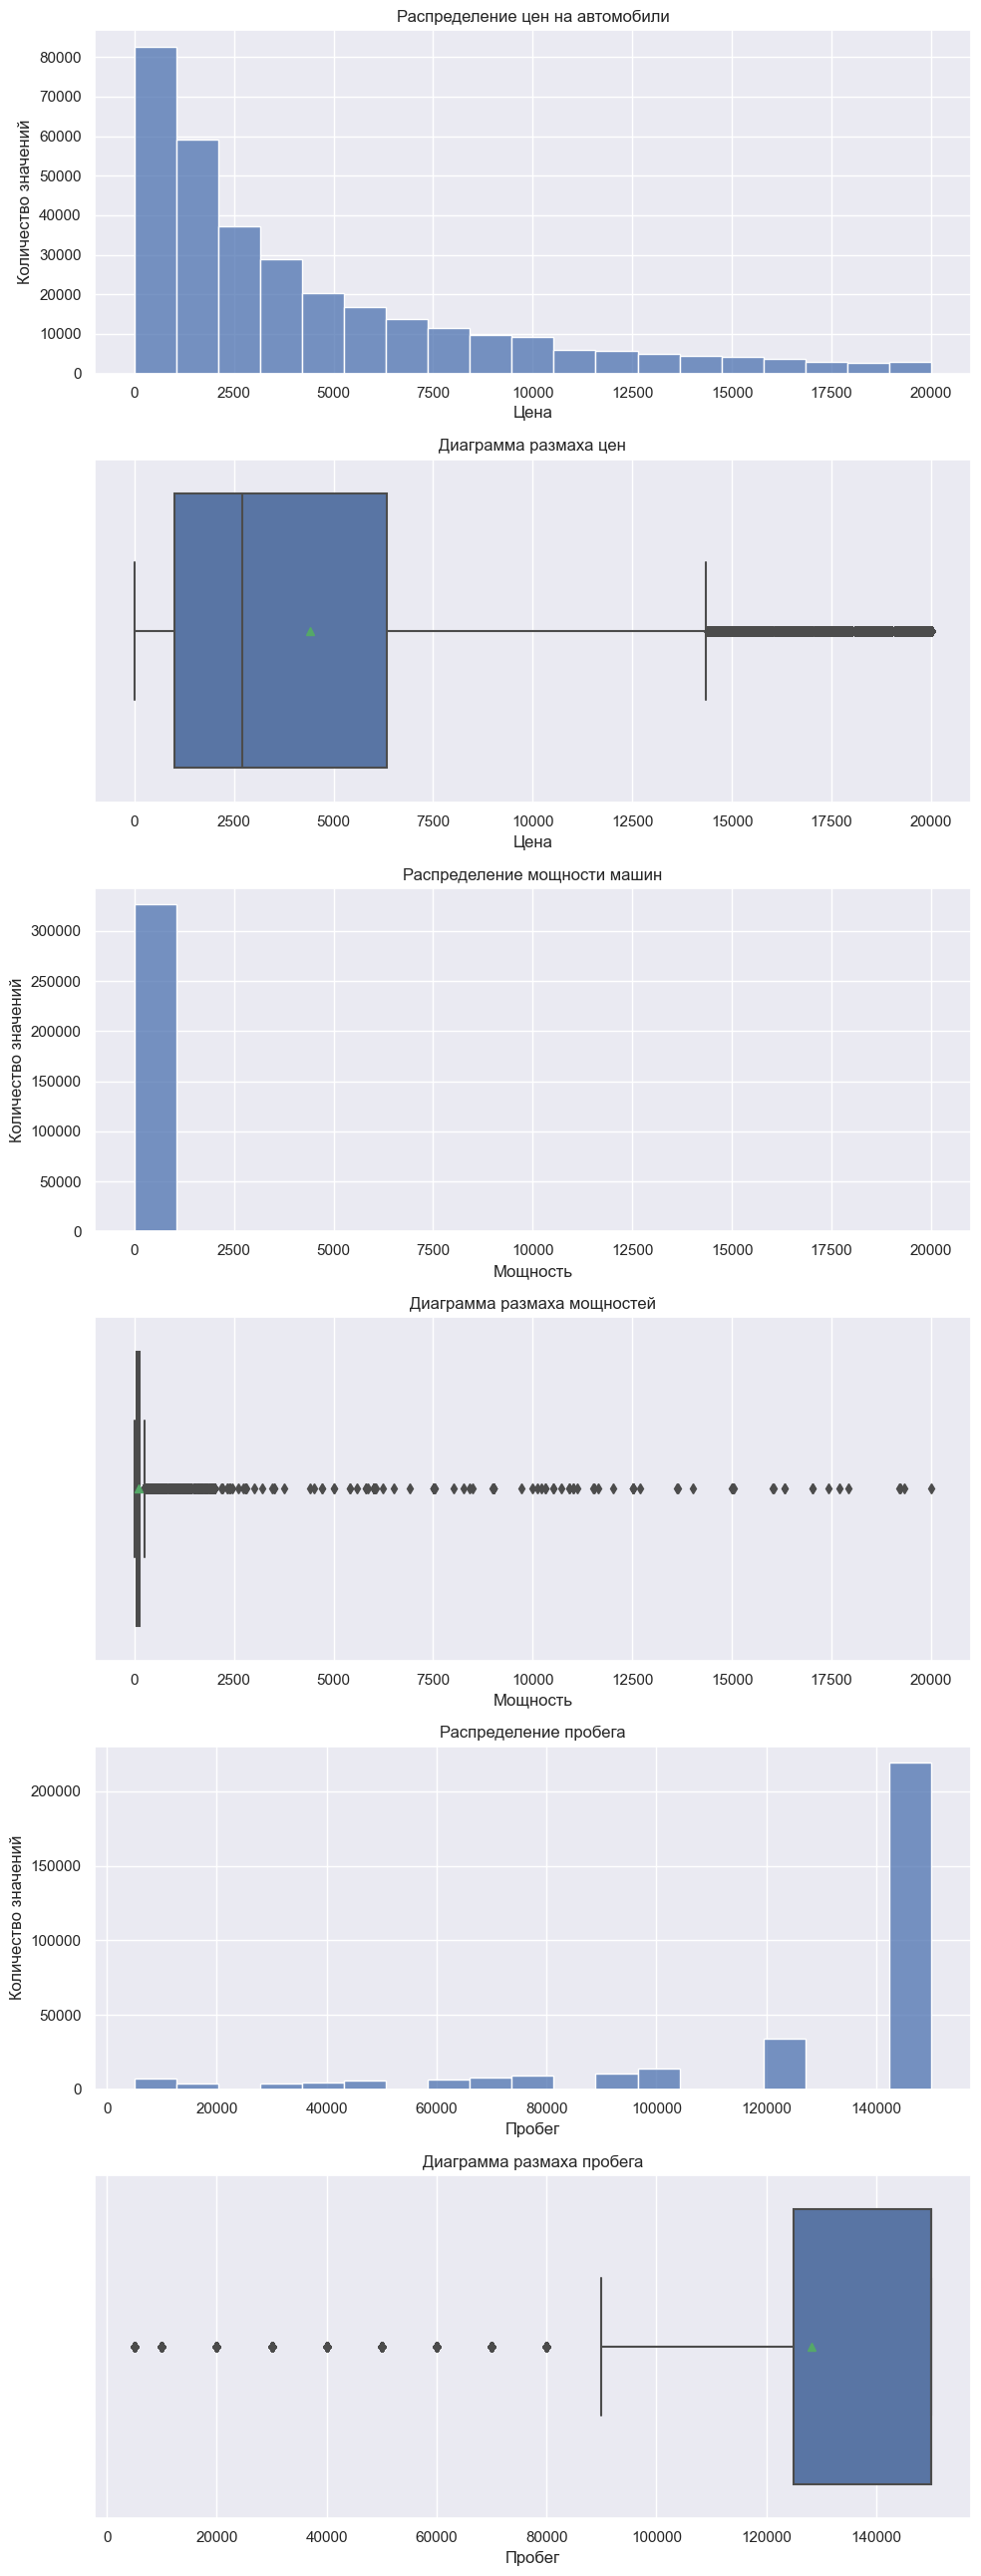

In [37]:
# Создаем переменные, которые станут агрументами функции
df = df
columns = ['Price','Power','Kilometer']
col_numb = len(columns)
subplots = col_numb * 2

# Количество корзин определим по правилу Стёрджеса: число bins равно log2(n) + 1, где n - количество наблюдений
bins = [round((math.log2(len(df)) + 1))] * col_numb
figsize = (10,26)
#title_h = ['Распределений общей суммы финансирования в USD','Распределение количества раундов финансирования','Распределение года основания стартапов']
#title_b = ['Диаграмма размаха общей суммы финансирования в USD','Диаграмма количества раундов финансирования','Диаграмма размаха лет основания стартапов']
title_h = ['Распределение цен на автомобили','Распределение мощности машин','Распределение пробега',]
title_b = ['Диаграмма размаха цен','Диаграмма размаха мощностей','Диаграмма размаха пробега']
y = ['Количество значений'] * col_numb
x = ['Цена','Мощность','Пробег'] * col_numb
y_b = [''] * col_numb

# Строим графики
plot_hist_box(df,columns,subplots,figsize,bins,title_h,title_b,y,x,y_b,x)

In [38]:
df = df.query('1800 < RegistrationYear < 2025')

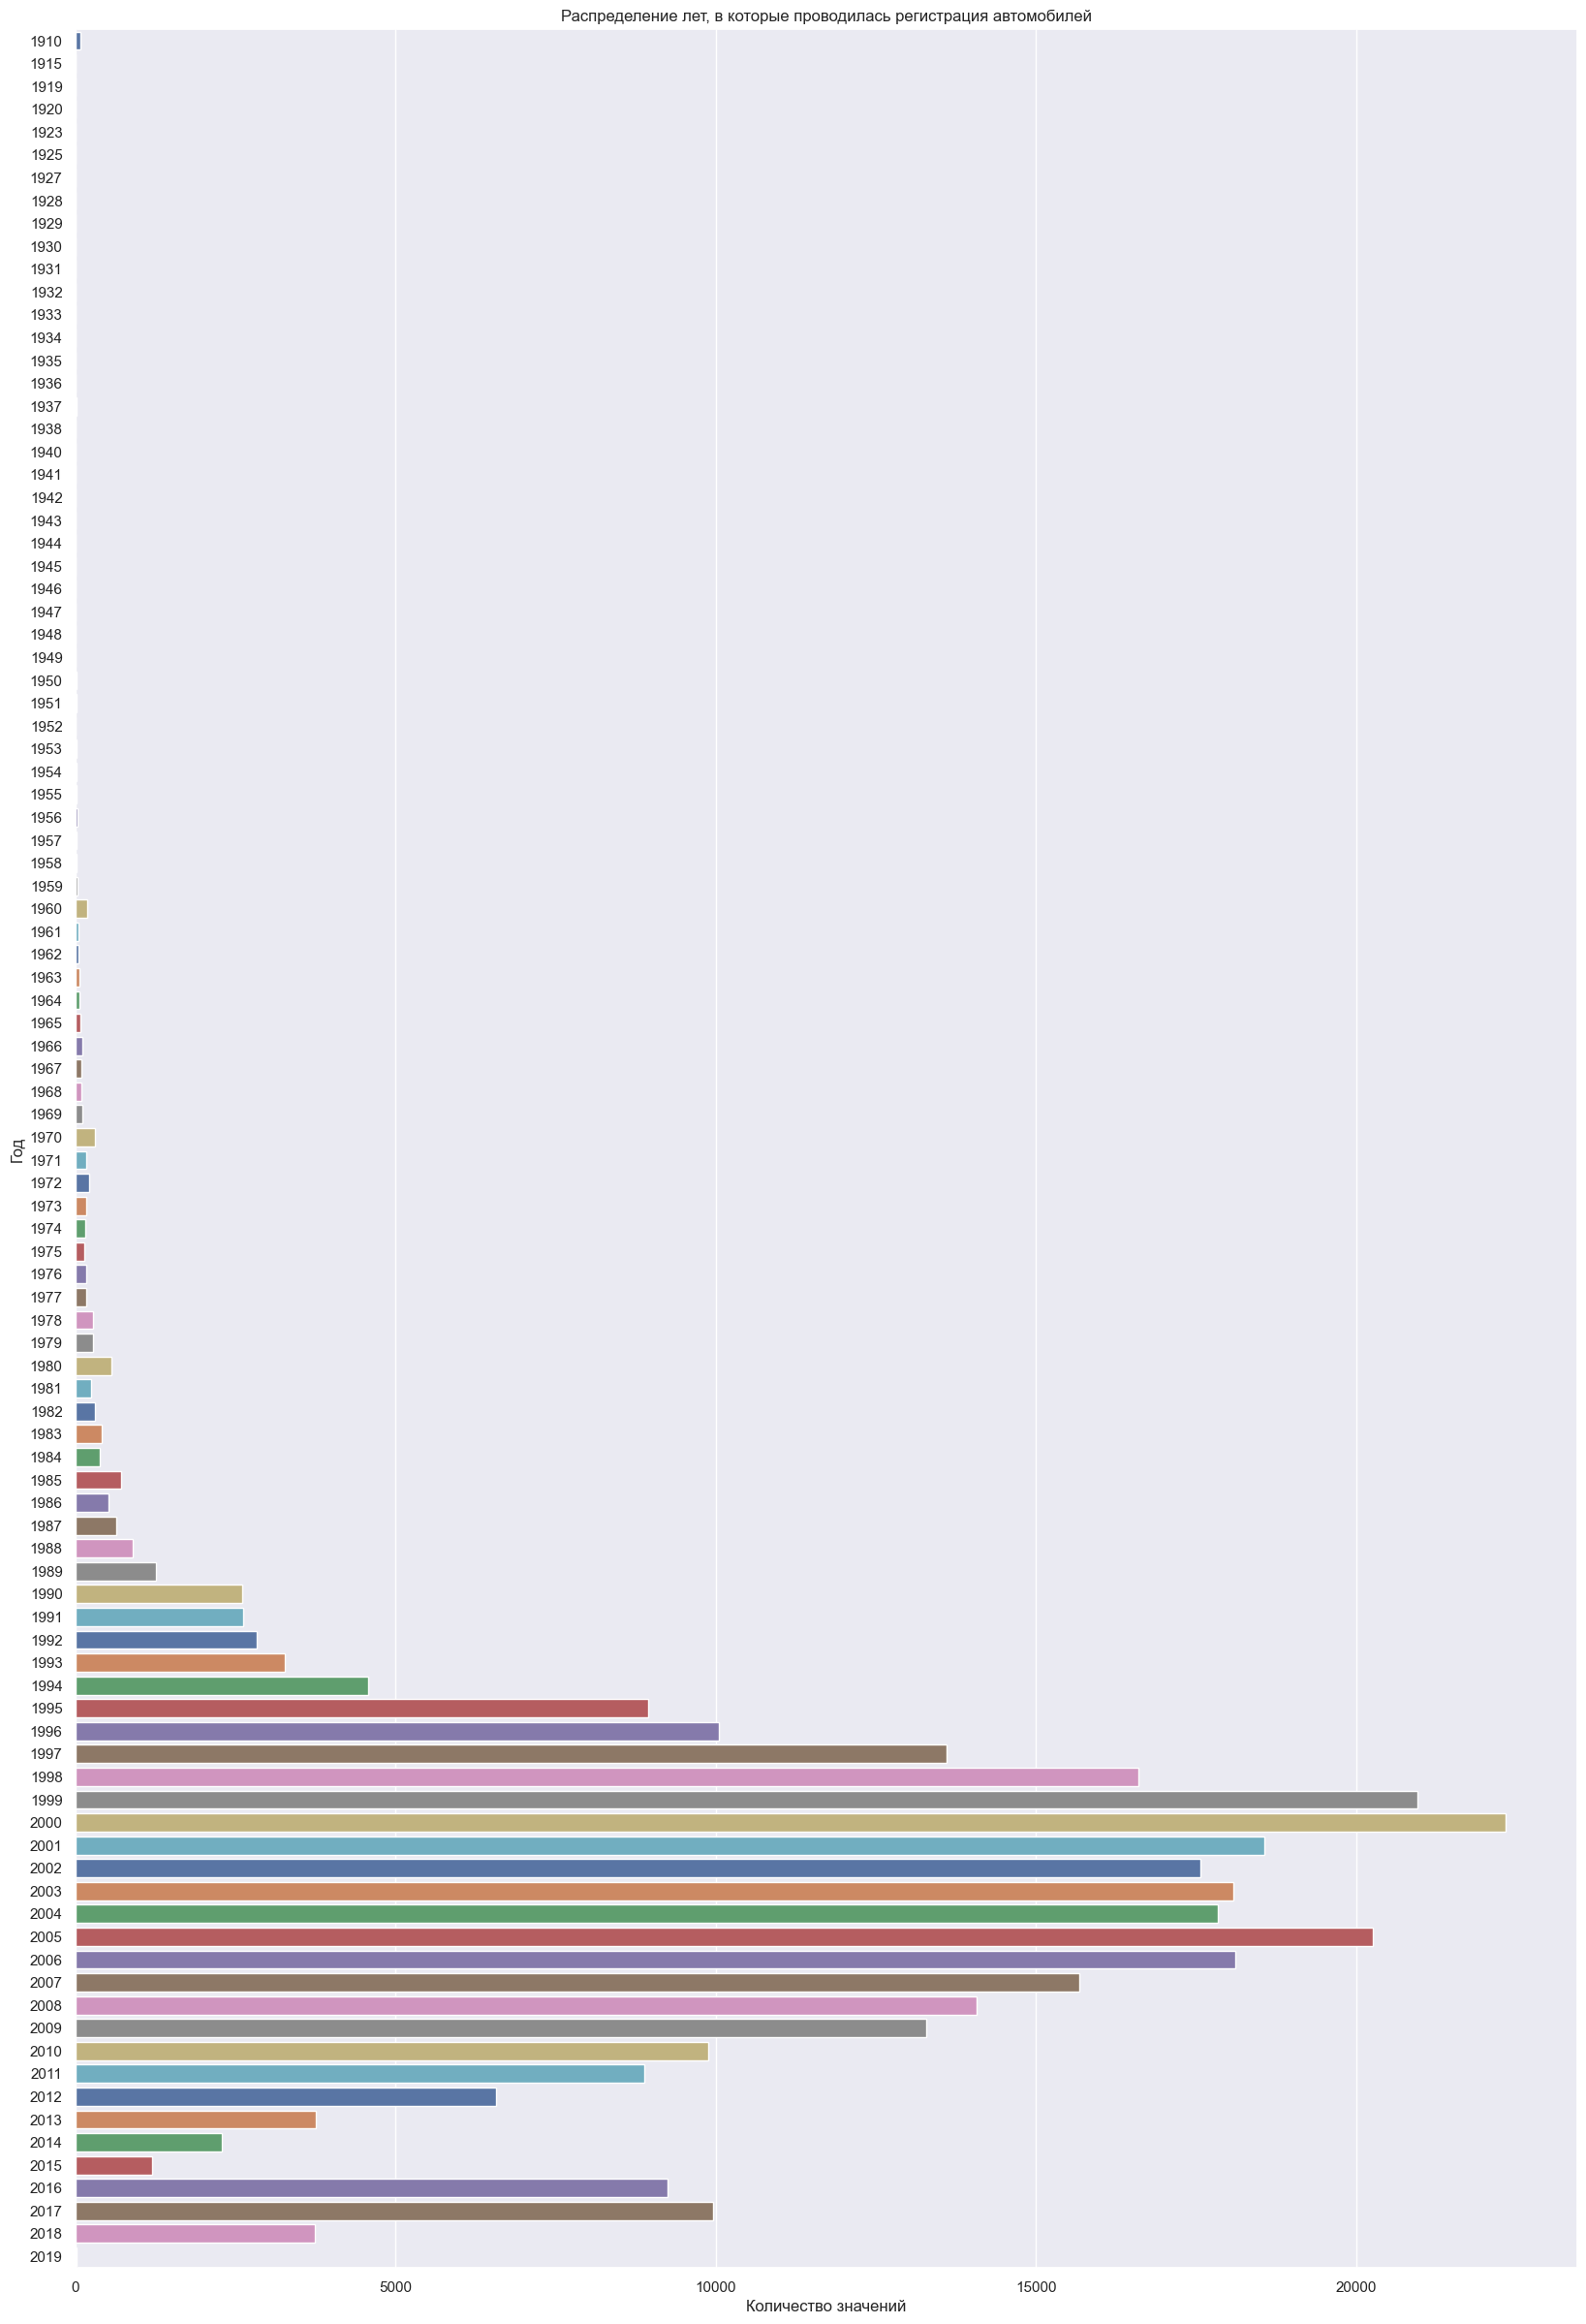

In [39]:
# Строим countplot для дискретных признаков
fig = plt.figure(figsize=(20,30))
sns.countplot(data=df, y='RegistrationYear', palette='deep')

plt.title('Распределение лет, в которые проводилась регистрация автомобилей')
plt.xlabel('Количество значений')
plt.ylabel('Год')
plt.show()

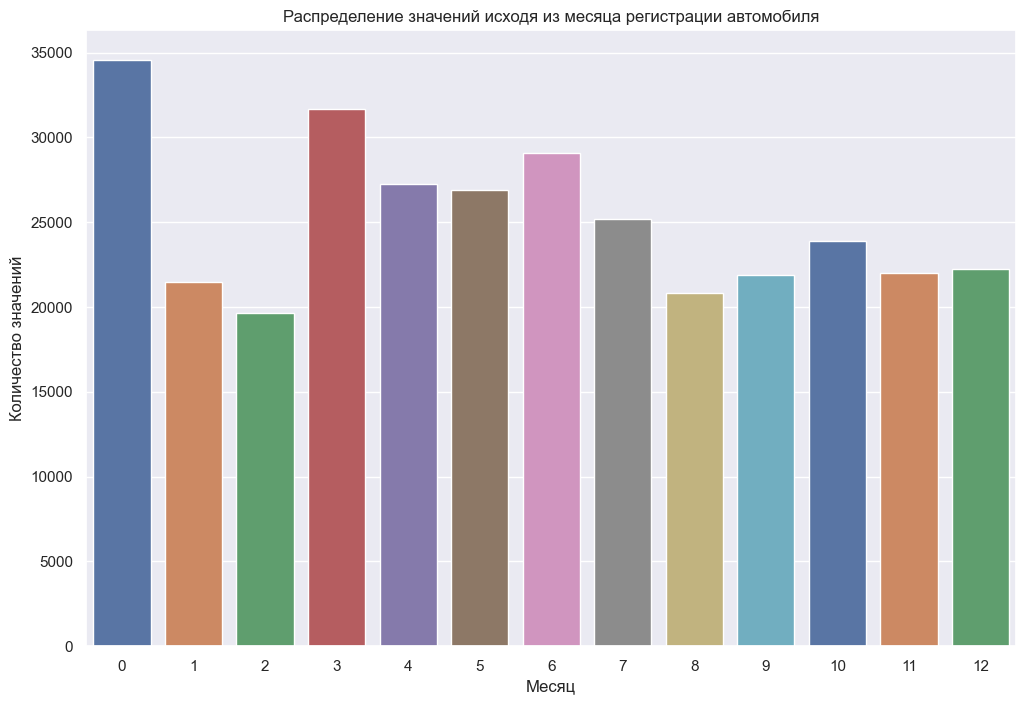

In [40]:
# Строим countplot для дискретных признаков
fig = plt.figure(figsize=(12,8))
sns.countplot(data=df, x='RegistrationMonth', palette='deep')

plt.title('Распределение значений исходя из месяца регистрации автомобиля')
plt.xlabel('Месяц')
plt.ylabel('Количество значений')
plt.show()

In [41]:
df.query('Price < 500').count()[0]

C:\Users\maksl\AppData\Local\Temp\ipykernel_25644\3492868253.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df.query('Price < 500').count()[0]


33364

In [42]:
df.query('not (40 < Power < 600)').count()[4]

C:\Users\maksl\AppData\Local\Temp\ipykernel_25644\21112589.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df.query('not (40 < Power < 600)').count()[4]


38937

In [43]:
df.query('RegistrationYear < 1960').count()[2]

C:\Users\maksl\AppData\Local\Temp\ipykernel_25644\3648662418.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df.query('RegistrationYear < 1960').count()[2]


337

In [44]:
df = df.query('not (Model == "601")')

По гистограммам можно заметить, что в наших данных очень много машин с нулевой стоимостью, а также околонулевой мощностью. Отфильтруем эти аномалии, поставим в качестве минимальной цену в 500 евро, при этом также отфильтруем мощность по максимуму, так как машина с мощностью более 600 л.с. явная аномалия для машин продающихся по объявлению(хотя есть ограниченное количество машин с мощностью превышающей это значение).

Также, отфильтруем значение по дате регистрации, самый первый автомобиль был создан в 1885 году, маловероятно, что в нашем датасете сохранились даже такие раритеты, по графику видно, что можно отфильтровать автомобили зарегистрированные до 1960-1970 годов.

В значениях признака по месяцу регистрации достаточно часто встречается значение "0", предположим, что имелся в виду первый месяц и заменим на "1".

In [45]:
# Отфильтровываем признаки
df = df.query('40 < Power < 600')
df = df.query('Price > 500')
df = df.query('1960 < RegistrationYear < 2017')

# Преобразуем значение в столбце по месяцу
df['RegistrationMonth'] = df['RegistrationMonth'].apply(lambda i: 1 if i == 0 else i)

df = df.reset_index(drop=True)

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,"251,494.000","251,494.000","251,494.000","251,494.000","251,494.000"
mean,"5,202.949","2,003.220",123.917,"127,669.030",6.115
std,"4,611.711",6.247,53.579,"36,884.532",3.468
min,501.000,"1,961.000",41.000,"5,000.000",1.000
25%,"1,600.000","2,000.000",84.000,"125,000.000",3.000
50%,"3,500.000","2,004.000",116.000,"150,000.000",6.000
75%,"7,494.000","2,007.000",150.000,"150,000.000",9.000
max,"20,000.000","2,016.000",585.000,"150,000.000",12.000


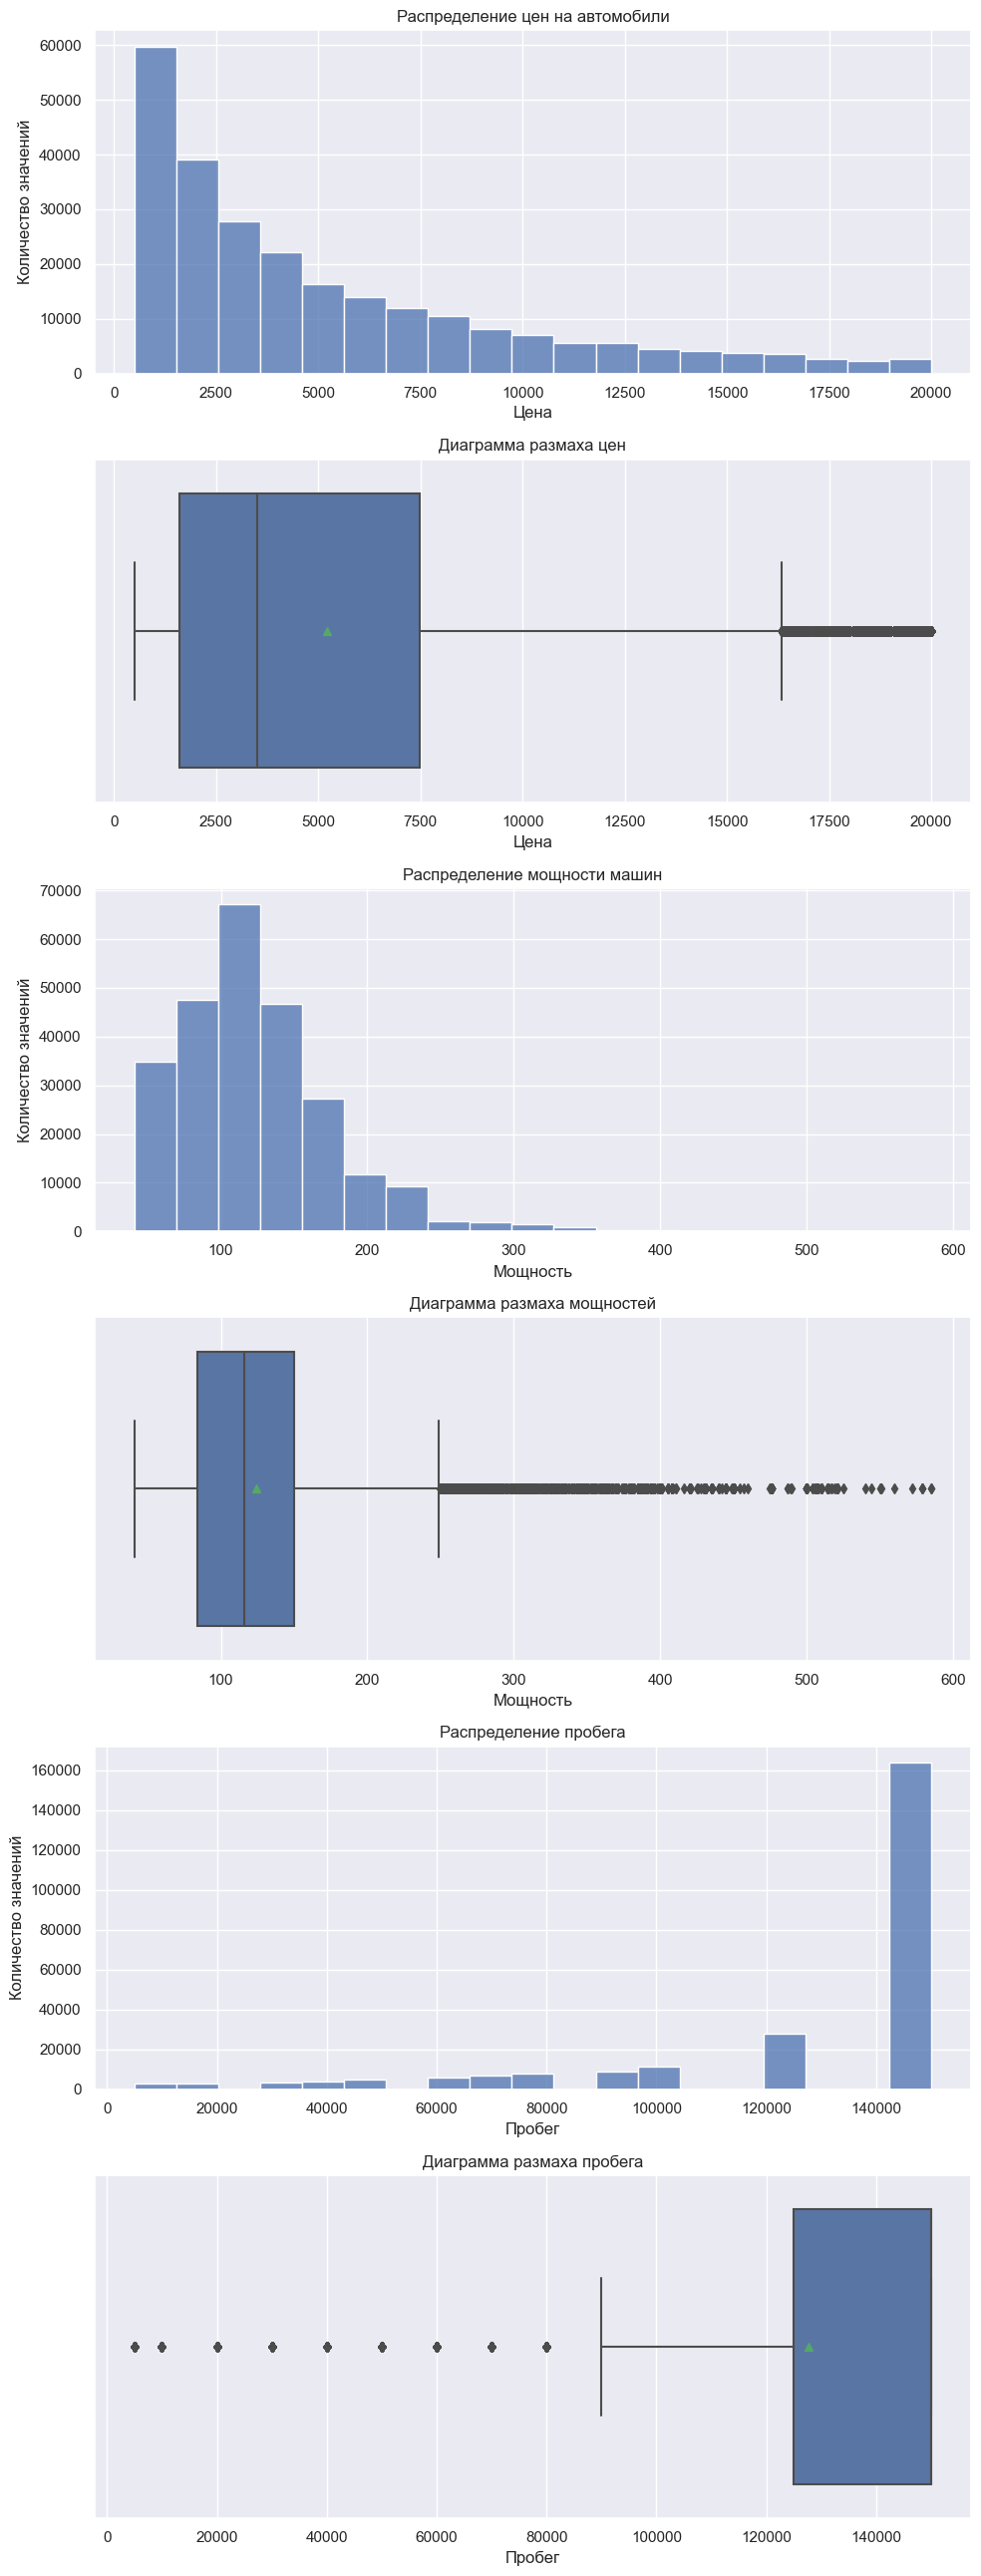

In [46]:
# Создаем переменные, которые станут агрументами функции
df = df
columns = ['Price','Power','Kilometer']
col_numb = len(columns)
subplots = col_numb * 2

# Количество корзин определим по правилу Стёрджеса: число bins равно log2(n) + 1, где n - количество наблюдений
bins = [round((math.log2(len(df)) + 1))] * col_numb
figsize = (10,26)

title_b = ['Диаграмма размаха цен','Диаграмма размаха мощностей','Диаграмма размаха пробега']
y = ['Количество значений'] * col_numb
x = ['Цена','Мощность','Пробег'] * col_numb
y_b = [''] * col_numb

# Строим графики
plot_hist_box(df,columns,subplots,figsize,bins,title_h,title_b,y,x,y_b,x)

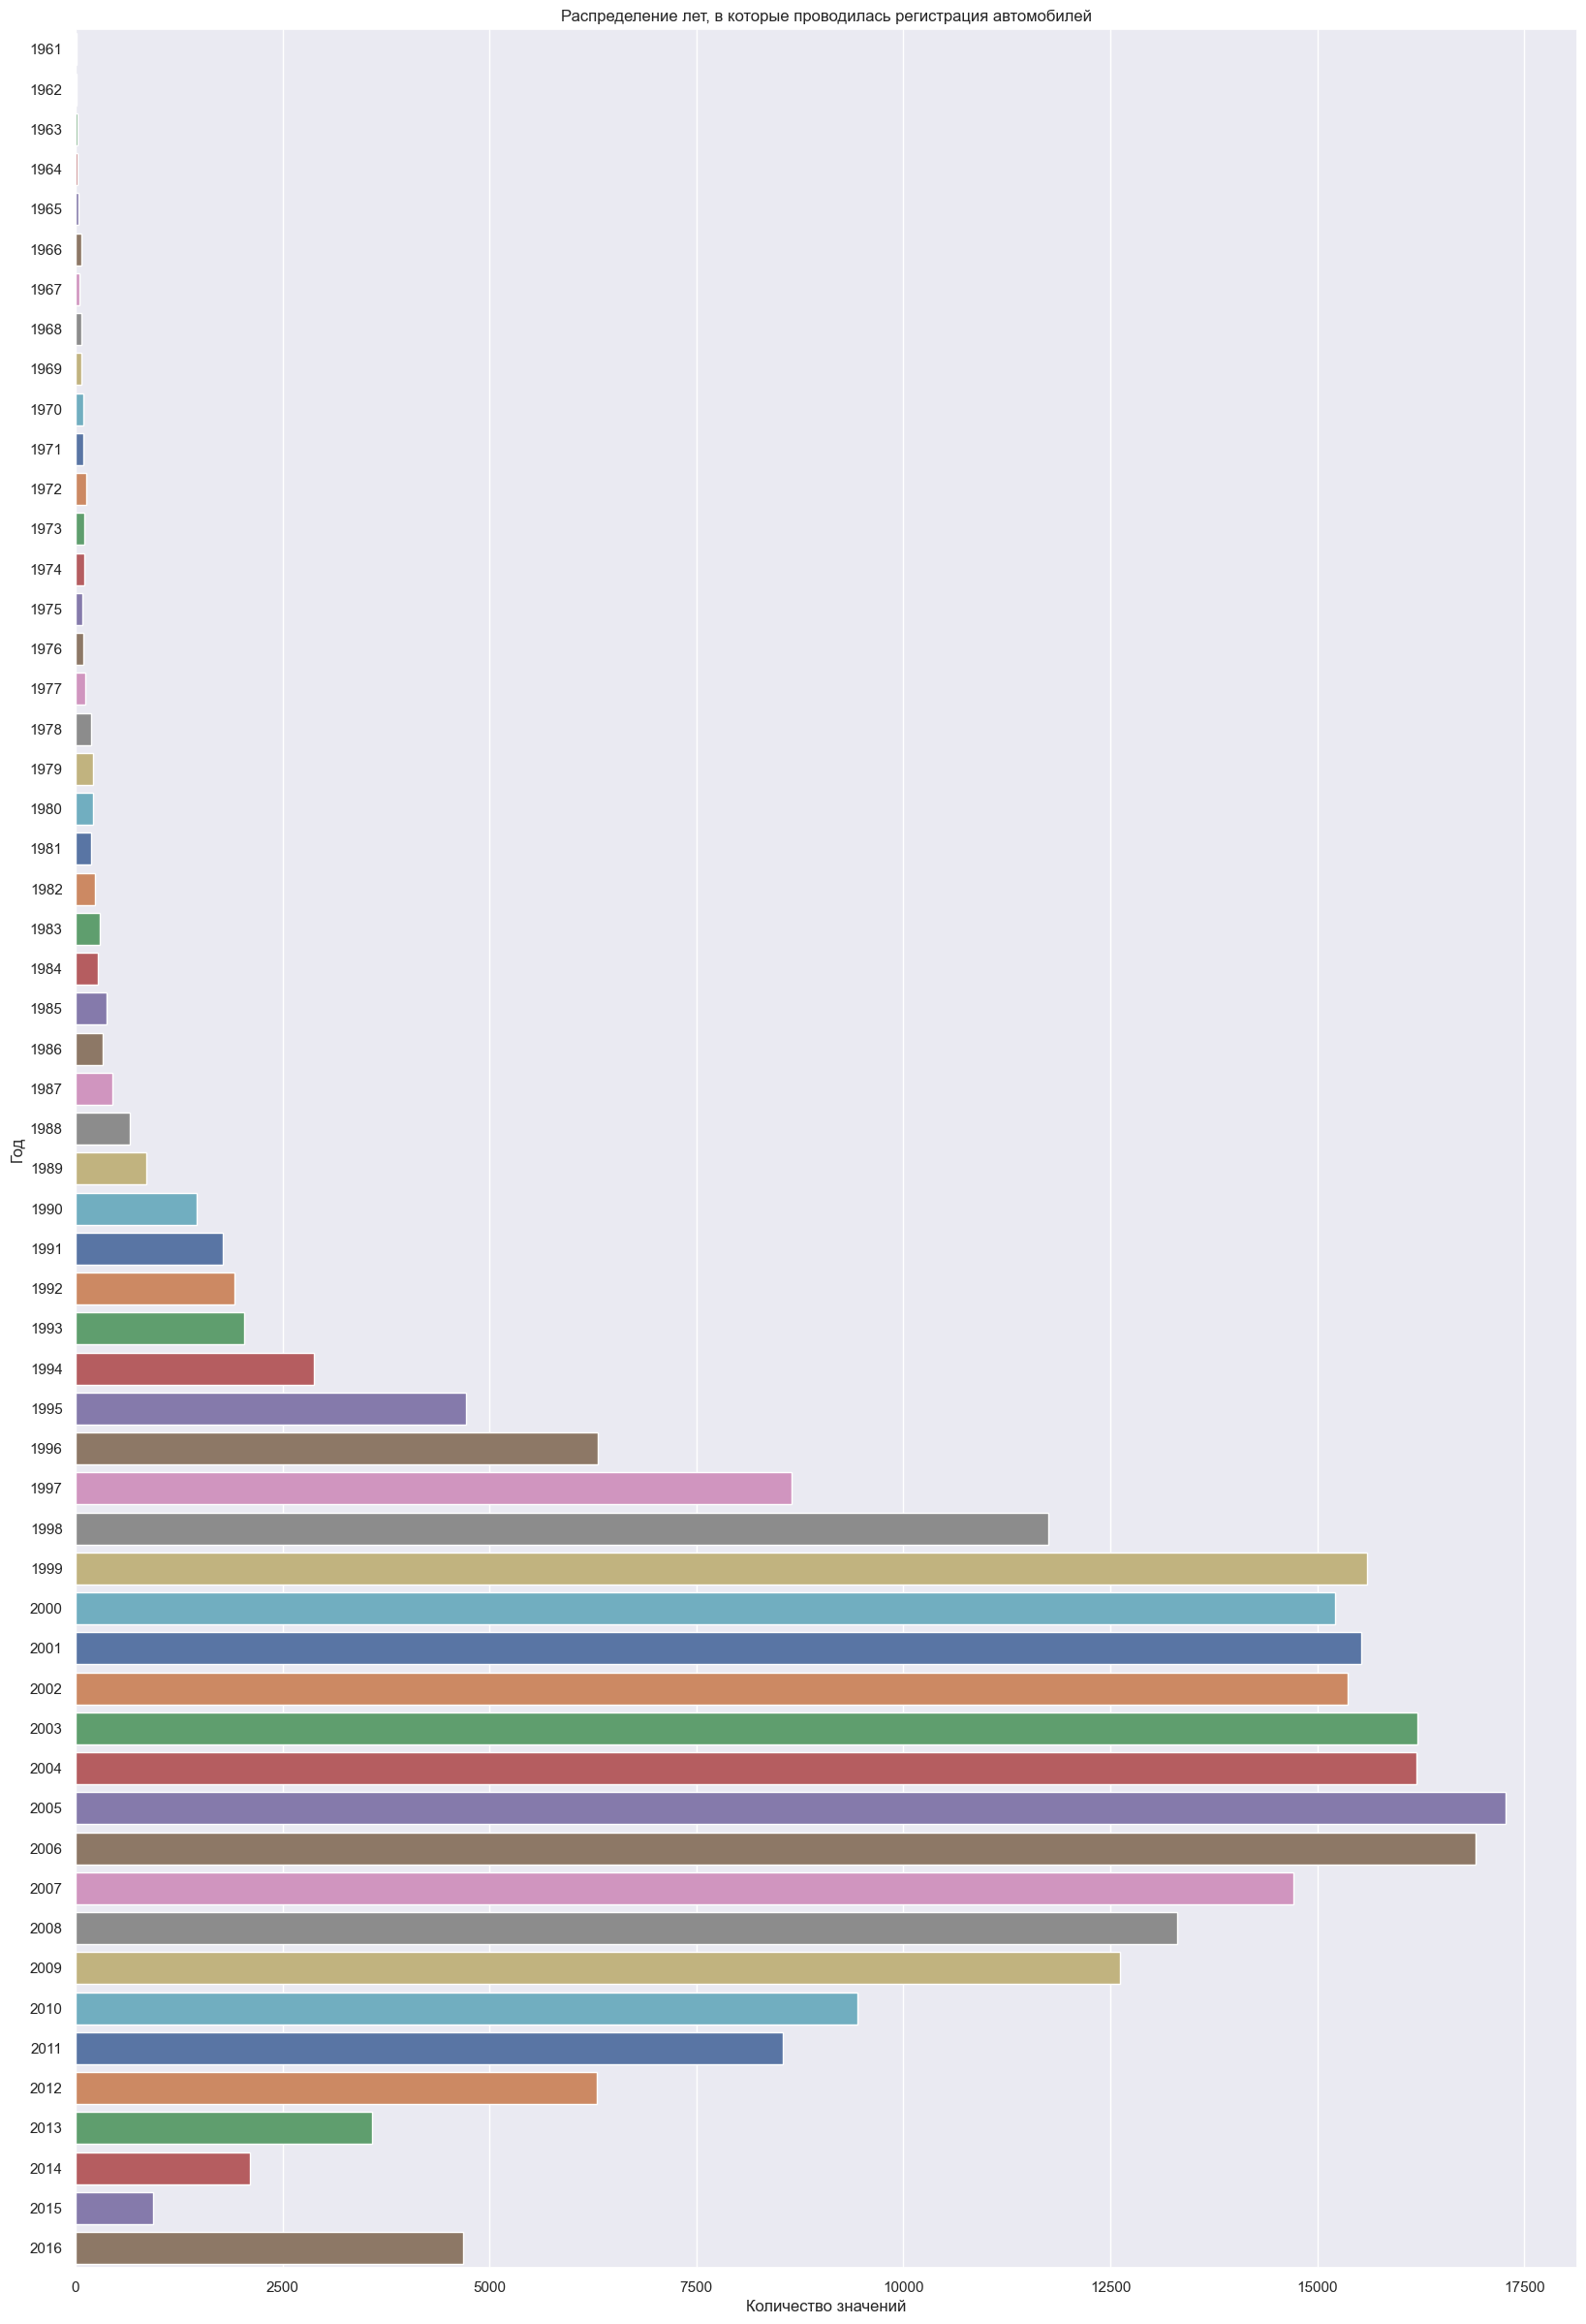

In [47]:
# Строим countplot для дискретных признаков
fig = plt.figure(figsize=(20,30))
sns.countplot(data=df, y='RegistrationYear', palette='deep')

plt.title('Распределение лет, в которые проводилась регистрация автомобилей')
plt.xlabel('Количество значений')
plt.ylabel('Год')
plt.show()

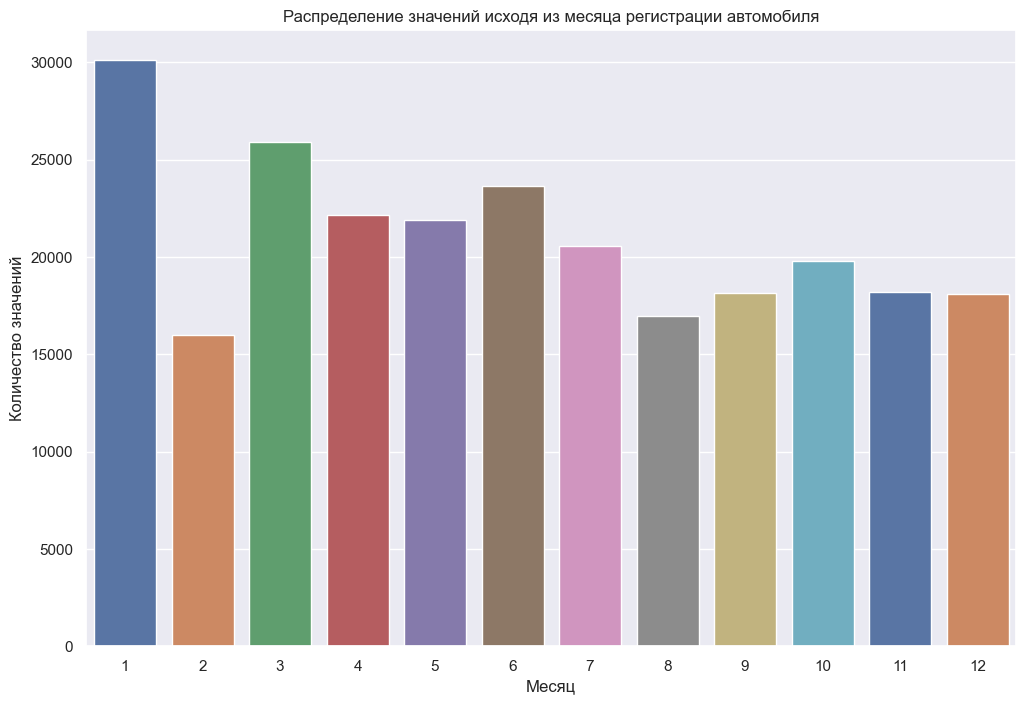

In [48]:
# Строим countplot для дискретных признаков
fig = plt.figure(figsize=(12,8))
sns.countplot(data=df, x='RegistrationMonth', palette='deep')

plt.title('Распределение значений исходя из месяца регистрации автомобиля')
plt.xlabel('Месяц')
plt.ylabel('Количество значений')
plt.show()

Избавились от некоторого количества выбросов, удалили около 29% от изначального объема датасета, если с обучением моделей возникнут проблемы, возможно, вернемся к этому шагу и попробуем изменить логику фильтрации аномалий и части выбросов, ведь это достаточно большое значение.

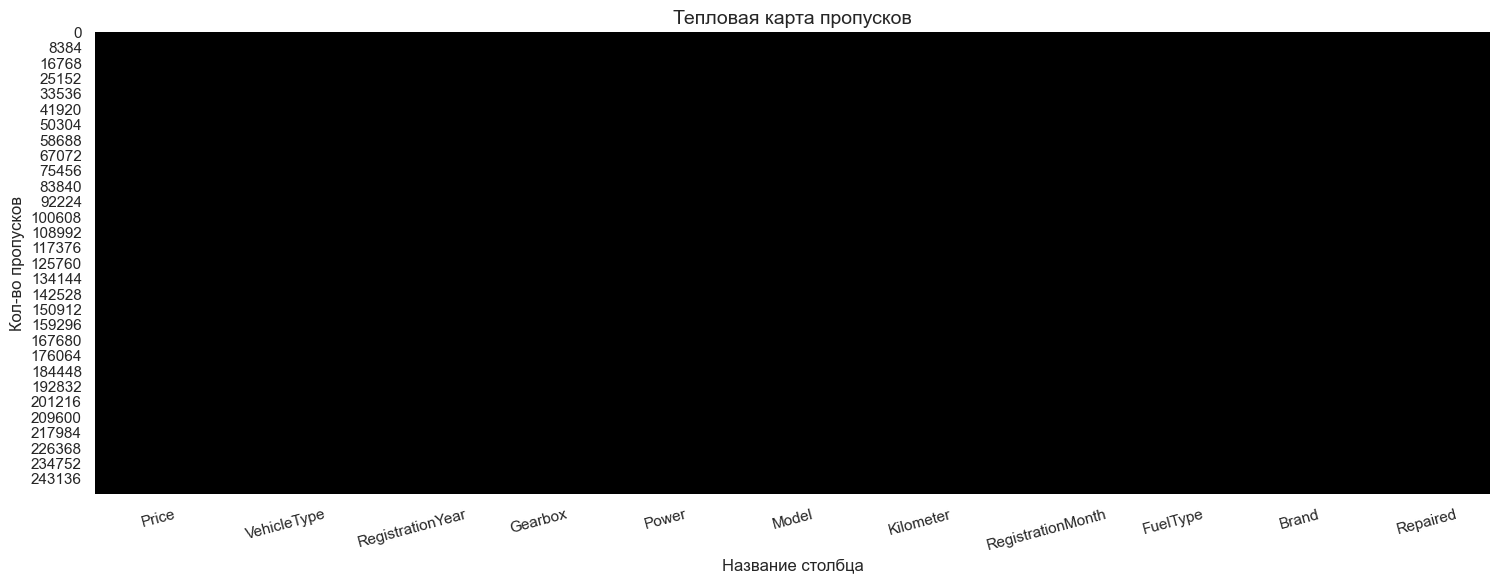

,sum_isna,percent_isna,value_type
Price,0,0.000,int64
VehicleType,0,0.000,object
RegistrationYear,0,0.000,int64
Gearbox,0,0.000,object
Power,0,0.000,int64
Model,0,0.000,object
Kilometer,0,0.000,int64
RegistrationMonth,0,0.000,int64
FuelType,0,0.000,object
Brand,0,0.000,object


In [49]:
display(numb_isna(df,True))
print('\n\n')

In [50]:
df_size(df)

Размер датафрейма: строк - 251494, столбцов - 11


### Корреляционный анализ

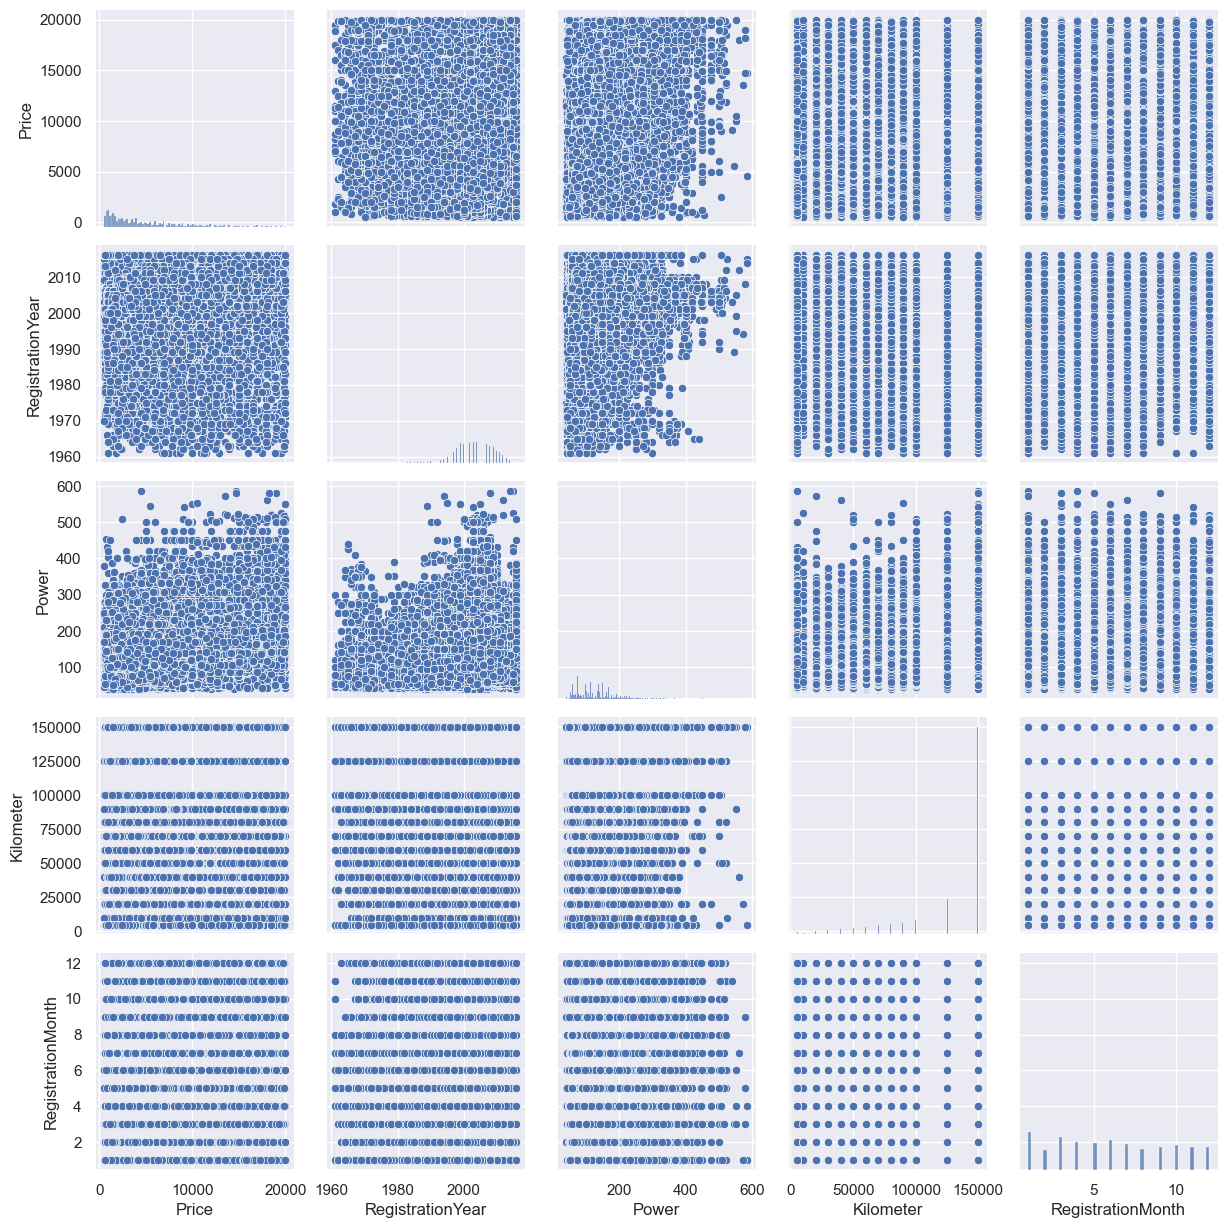

In [51]:
# Посмотрим попарные отношения между признаками датафрейма обучающей выборки
sns.pairplot(df);

Линейных зависимостей между данными не обнаружено.

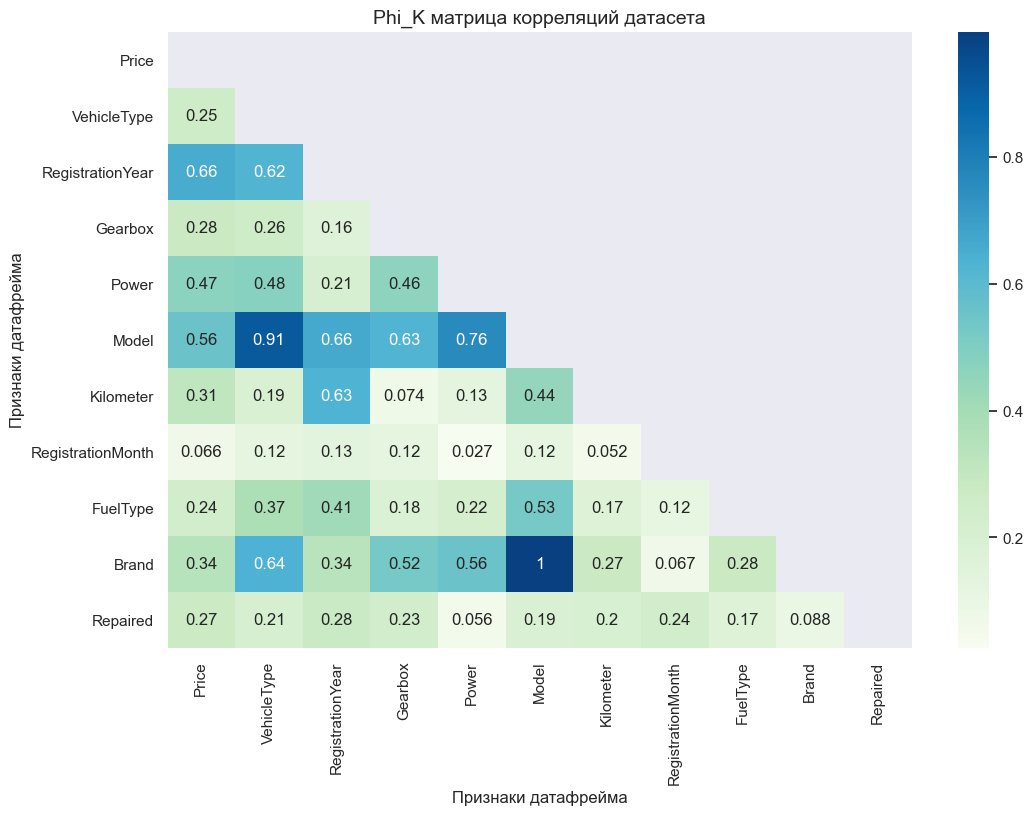

In [52]:
# Вычисление матрицы корреляции с использованием phik
corr_matrix_phik = df.phik_matrix(interval_cols=['Price','Power','Kilometer'])

# Маска для устранения дублирования в визуализации
mask = np.zeros_like(corr_matrix_phik)
mask[np.triu_indices_from(mask)] = True

# Построение heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(corr_matrix_phik, annot=True,cmap='GnBu',mask=mask)
plt.title('Phi_K матрица корреляций датасета', fontsize=14)
plt.ylabel('Признаки датафрейма')
plt.xlabel('Признаки датафрейма')
plt.show();

Можно заметить наличие очень большой мультиколлинеарности между брэндом и моделью, так что уберем признак с обозначением брэнда машины, так как он меньше коррелирует с нашим таргетом. Также, минимальная корреляция между месяцем и ценой.

Видна хорошая корреляция цены автомобиля с годом регистрации, моделью, а также умеренная с целом рядом признаков: мощность, пробег, наличие ремонта.

In [53]:
df = df.drop(['Brand','RegistrationMonth'], axis=1)

In [54]:
df.head(10)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Repaired
0,18300,coupe,2011,manual,190,other,125000,gasoline,yes
1,9800,suv,2004,auto,163,grand,125000,gasoline,unknown
2,1500,small,2001,manual,75,golf,150000,petrol,no
3,3600,small,2008,manual,69,fabia,90000,gasoline,no
4,650,sedan,1995,manual,102,3er,150000,petrol,yes
5,2200,convertible,2004,manual,109,2_reihe,150000,petrol,no
6,14500,bus,2014,manual,125,c_max,30000,petrol,unknown
7,999,small,1998,manual,101,golf,150000,other,unknown
8,2000,sedan,2004,manual,105,3_reihe,150000,petrol,no
9,2799,wagon,2005,manual,140,passat,150000,gasoline,yes


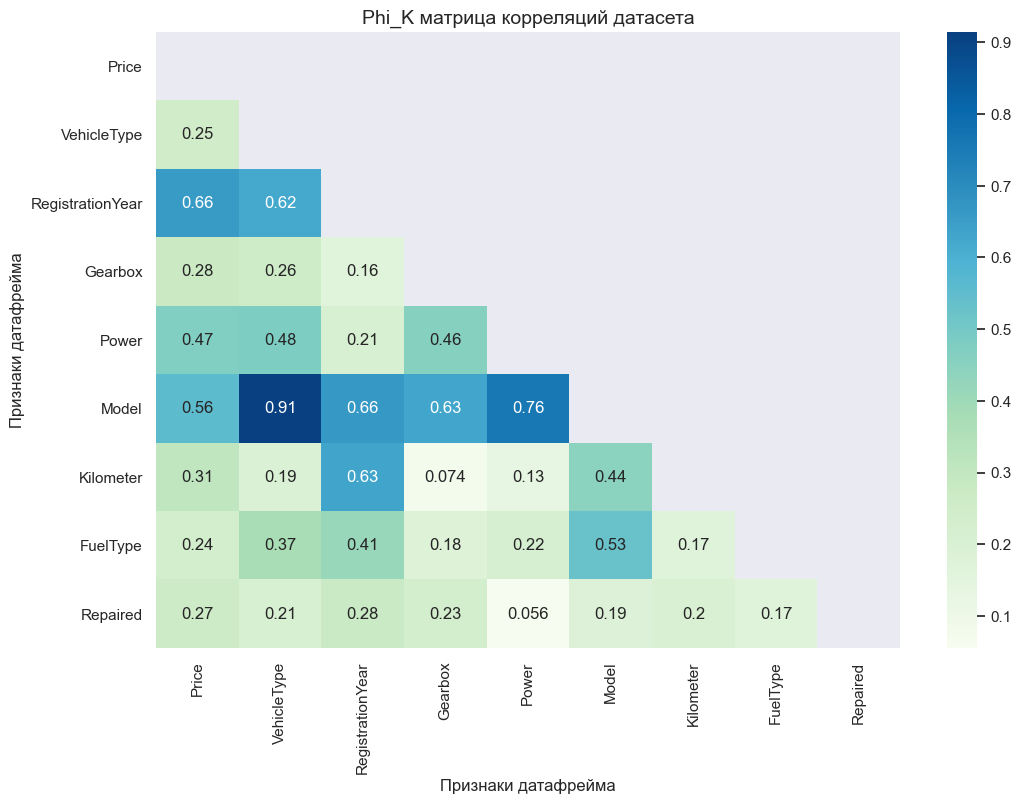

In [55]:
# Вычисление матрицы корреляции с использованием phik
corr_matrix_phik = df.phik_matrix(interval_cols=['Price','Power','Kilometer'])

# Маска для устранения дублирования в визуализации
mask = np.zeros_like(corr_matrix_phik)
mask[np.triu_indices_from(mask)] = True

# Построение heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(corr_matrix_phik, annot=True,cmap='GnBu',mask=mask)
plt.title('Phi_K матрица корреляций датасета', fontsize=14)
plt.ylabel('Признаки датафрейма')
plt.xlabel('Признаки датафрейма')
plt.show();

### Вывод по подготовке данных
В этом разделе проекта, мы реализовали извелечение и загрузку данных, предварительно ознакомились с ними и проанализировали возможные неточности.

Затем, принялись за предобработку данных включавшую в себя несколько шагов и проверок: корректность имен столбцов и типов данных, анализ и обратка пропусков, исследоваиние явных и неявных дубликатов. В процессе загрузки в датафрейм мы преобразовали даты в нужный формат, остальные столбцы не потребовали изменений. Названия в датафрейме представлены в формате CamelCase, обошлись без вноса корректировок. При анализе пропусков заметили достаточно большое количество NaN значений, от 5% до 20%, в признаках: _Gearbox_,_Model_,_VehicleType_, _Fueltype_, _Repaired_. Для их устранения создали новую категорию, либо причислили к одной из старых. При оценке дубликатов, выявили несколько из них и удалили, неявных дубликатов в данных найдено не было.
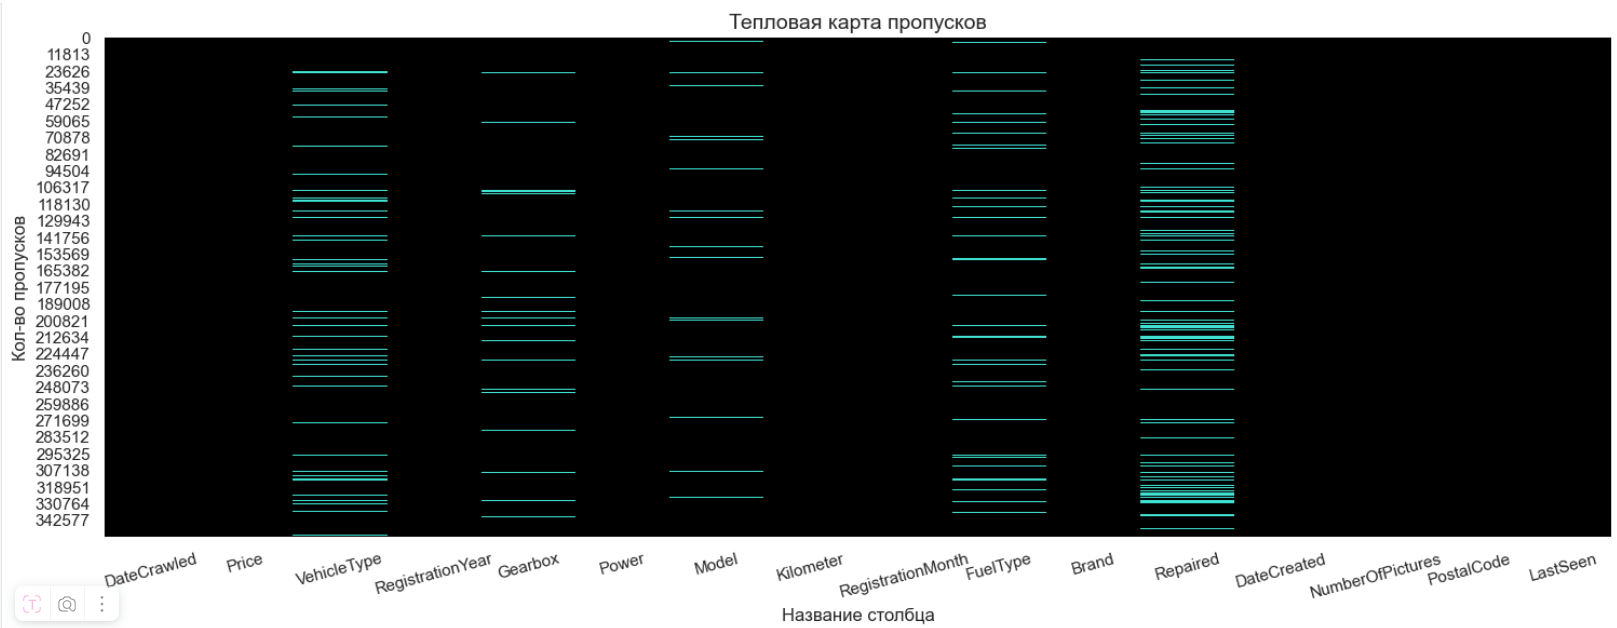

После этого мы начали исследовать данные, чтобы выявить выбросы и аномалии. Мы проанализировали гистограммы, чтобы оценить распределение признаков. Также мы изучили базовые статистические показатели.В данных оказалось много машин с очень низкой стоимостью и мощностью. Мы удалили эти аномалии, исключив машины с нулевой ценой и мощностью. Также мы ограничили максимальную мощность, поскольку машина с мощностью более 3000 — это явное отклонение от нормы. Кроме того, мы отфильтровали данные по дате регистрации, установив диапазон допустимых дат. Значения «0» для месяца регистрации были заменены на значения первого месяца. В результате фильтрации, мы удалили около 17% от всего датасета.

Последним шагом в этом разделе был корреляционный анализ. Заметили, что существует сильная взаимосвязь между брендом и моделью автомобиля, поэтому исключили признак, связанный с брендом, поскольку он слабо коррелировал с нашим таргетом в виде цены авто. Также заметили очень слабую корреляция между ценой автомобиля и месяцем его продажи, решили удалить этот признак из датасета. Убедились, что цена автомобиля сильно зависит от года выпуска, модели, а также от таких характеристик, как мощность, пробег и наличие ремонта.


## Обучение моделей

Перед тем, как начать обучать модели, нам нужно разделить данные на 3 выборки:
- тренировочную, на которой модель будет обучаться;
- валидационную, на которой будем проверять качество модели с подобранными гиперпараметрами
- тестовую, для которой будут реализованы предсказания

Для оценки работы моделей будем использовать метрику RMSE.

In [56]:
# Убираем из входных данных таргет
df_X = df.drop('Price', axis=1)

# На тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(
    df_X, 
    df['Price'],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE)

In [57]:
display(X_train.shape)
display(X_test.shape)

(176045, 8)

(75449, 8)

### LinearRegression и DecisionTreeRegressor

Для начала обучим парочку обычных моделей регрессии(не градиентного бустинга). Возьмем дерево решений и линейную регрессию.

In [58]:
# Выделяем столбцы для кодирования и масштабирования
ord_columns = ['Model']
ohe_columns = ['VehicleType','Gearbox','FuelType','Repaired']
num_columns = df_X.select_dtypes(include='number').columns.tolist()

In [59]:
# Создаем пайплайн для кодирования признаков
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')),
    ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

ord_pipe = Pipeline([
    ('simpleImputer_ord_before', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='other')),
    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = np.nan)),
    ('simpleImputer_ord_after', SimpleImputer(missing_values=np.nan, strategy='constant'))
])

In [60]:
# Добавляем масшабирование численных признаков
column_transformer = make_column_transformer(
    ((ohe_pipe),ohe_columns),
    ((ord_pipe),ord_columns),
    (MinMaxScaler(), num_columns),
    remainder='passthrough')

In [61]:
# Задаем модель и объединяем в общий пайплайн
model = LinearRegression()
pipeline = make_pipeline(column_transformer, model)

pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'FuelType', 'Repaired']),
                                                 ('pipeline-2',
                                                  Pipe...impleImputer_ord_before',
                                                                   SimpleImputer(fill_value='other',
                                                                                 strategy='constant')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('simpleImputer_ord_after',
                                                                   SimpleImputer(strategy='constant'))]),
                                                  ['Model']),
                                                 ('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['RegistrationYear', 'Power',
                                                   'Kilometer'])])),
                ('linearregression', LinearRegression())])

В качестве гиперпараметров будем использовать разные метода масшатбирования, а для дерева решения его глубину.

In [62]:
# Указание метода для масштабирования числовых признаков в качестве гиперпараметра, 
# также разных моделей МО и их гиперпараметров
params_distr = [
    
    # Словарь для модели DTC
    {
        'linearregression' : [DecisionTreeRegressor()],
        'linearregression__max_depth' : range(12,20),
        'columntransformer__minmaxscaler' : [RobustScaler(),StandardScaler(),'passthrough'] 
    },
    
        # Словарь для модели LinearRegression
    {
        'linearregression' : [LinearRegression()],
        'columntransformer__minmaxscaler' : [RobustScaler(),StandardScaler(),'passthrough']
    },
]

Для получения болле быстрого результата, сначала произведем перебор гиперпараметров в случайном порядке.

In [63]:
# Поиск гиперпараметров
rand_search = RandomizedSearchCV(
    pipeline, 
    param_distributions = params_distr,
    cv = 5,
    scoring = 'neg_root_mean_squared_error',
    n_jobs = -1,
    random_state=RANDOM_STATE
)

In [64]:
%%time
# Рассмотрение оценок и лучшей модели
rand_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', rand_search.best_estimator_)
print('Метрика RMSE на кросс-валидации для лучшей модели:\n', round(rand_search.best_score_, 5))

Лучшая модель и её параметры:

 Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'F

А теперь, переберем уже все параметры по сетке и найдем наилучшую модель.

In [65]:
# Поиск гиперпараметров
grid_search = GridSearchCV(
    pipeline, 
    param_grid = params_distr,
    cv = 5,
    scoring = 'neg_root_mean_squared_error',
    n_jobs = -1
)

In [66]:
%%time
# Рассмотрение оценок и лучшей модели на тренировочной выборке
grid_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
rmse_cv_dtr = round(grid_search.best_score_, 3)
print('Метрика rmse для лучшей модели:\n', rmse_cv_dtr)

Лучшая модель и её параметры:

 Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'F

Чтобы оценить скорость лучшей модели, создадим новый пайплайн, который будет включать в себя лучшие из подобранных ранее средств кодирования и масштабирования, а также модель с оптимальными гиперпараметрами.

In [67]:
# Составляем новый пайплайн для модели с лучшими параметрами
column_transformer_b = make_column_transformer(
    ((ohe_pipe),ohe_columns),
    ((ord_pipe),ord_columns),
    (StandardScaler(), num_columns),
    remainder='passthrough')

# Задаем модель и объединяем в общий пайплайн
model_best = DecisionTreeRegressor(max_depth=13,random_state=RANDOM_STATE)
pipeline_best = make_pipeline(column_transformer_b, model_best)

In [68]:
# Функция для подсчета времени, которое заняло у модели на обучение и предсказание
def tr_pr_time(start_tr, end_tr, start_pr, end_pr):
    # Считаем время обучения
    train_time = round((end_tr - start_tr), 4)
    # Считаем время предсказания
    predict_time = round((end_pr - start_pr), 4)
    print(f'Время обучения модели на тренировочной выборке: {train_time} c.')
    print(f'Время предсказания модели на тренировочной выборке: {predict_time} c.')
    # Возвращаем полученные значения
    return train_time, predict_time

In [69]:
# Время начала запуска обучения
start_tr = time()

# Обучение лучшей модели
pipeline_best.fit(X_train, y_train)

# Время окончания обучения
end_tr = time()

# Время начала запуска предсказания
start_pr = time()

# Получение предсказаний
pipeline_best.predict(X_train)

# Время окончания предсказания
end_pr = time()

# Расчет и вывод времени
train_time_dtr, predict_time_dtr = tr_pr_time(start_tr, end_tr, start_pr, end_pr)

Время обучения модели на тренировочной выборке: 0.8378 c.
Время предсказания модели на тренировочной выборке: 0.2513 c.


In [70]:
print('После обучения моделей зафиксируем результаты:')
print(f'1. Метрика лучшей из моделей, которой оказалось дерево решений с \
глубиной дерева равной 13-и, \n   равна {rmse_cv_dtr}.')
print(f'2. Время обучения модели - {train_time_dtr} с.')
print(f'3. Время реализации прогноза - {predict_time_dtr} с.')

После обучения моделей зафиксируем результаты:
1. Метрика лучшей из моделей, которой оказалось дерево решений с глубиной дерева равной 13-и, 
   равна -1939.335.
2. Время обучения модели - 0.8378 с.
3. Время реализации прогноза - 0.2513 с.


__Dummy Regressor__

Для сравнения адекватности модели, обучим "глупую" модель, которая будет предсказывать константу и посмотрим на качетсво таких предсказаний.

In [71]:
# Создание и обучение модели DummyRegressor 
dummy_model = DummyRegressor()
dummy_model.fit(X_train, y_train)

# Предсказание на тестовых данных
dummy_model_preds = dummy_model.predict(X_train)

print(f'Метрика RMSE для dummy модели на валидационной \
выборке: {round(root_mean_squared_error(y_train, dummy_model_preds), 5)}')

Метрика RMSE для dummy модели на валидационной выборке: 4618.13886


### LightGBM

Теперь, приступим к обучению модели градиентного бустинга LightGBM. Модель не умеет работать с признаками, которые представлены в формате object, поэтому заранее закодируем наши категориальные столбцы с помощью LabelEncoder.

In [72]:
# Задание категориальных столбцов
cat_features = ord_columns + ohe_columns

# Кодирование категориальных столбцов с помощью LabelEncoder
label_encoder = LabelEncoder()
X_train_le = X_train.copy()
X_test_le = X_test.copy()

for cat in cat_features:
    
    X_train_le[cat] = label_encoder.fit_transform(X_train[cat])
    X_test_le[cat] = label_encoder.transform(X_test[cat])

В качестве гиперпараметров будем использовать:
- количество деревьев (n_estimators): определяет общее количество деревьев, используемых в процессе обучения.
- глубину дерева (max_depth): устанавливает максимальную глубину каждого дерева в ансамбле.
- скорость обучения (learning_rate): определяет скорость, с которой модель обновляет веса при обучении.

In [73]:
# Создаем экземпляр модели LGBMR
model_lgr = LGBMRegressor(objective='rmse', metric='rmse',random_state=RANDOM_STATE)

# Гиперпараместры для перебора
params_lgr = [
    {'n_estimators':[100,150],
     'max_depth':[6,9,12], 
     'learning_rate':[0.1,0.15,0.2]}
]

# Поиск лучших гиперпараметров
grid_search_lgr = GridSearchCV(
    model_lgr, 
    param_grid = params_lgr,
    cv = 5,
    scoring = 'neg_root_mean_squared_error',
    n_jobs = -1
)

In [74]:
%%time
# Рассмотрение оценок и лучшей модели на тренировочной выборке
grid_search_lgr.fit(X_train_le, y_train)
print('Лучшая модель и её параметры:\n\n', grid_search_lgr.best_estimator_)
rmse_cv_lgr = round(grid_search_lgr.best_score_, 3)
print('Метрика rmse для лучшей модели:\n', rmse_cv_lgr)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 558
[LightGBM] [Info] Number of data points in the train set: 176045, number of used features: 8
[LightGBM] [Info] Start training from score 5205.956613
Лучшая модель и её параметры:

 LGBMRegressor(learning_rate=0.2, max_depth=12, metric='rmse', n_estimators=150,
              objective='rmse', random_state=29)
Метрика rmse для лучшей модели:
 -1637.784
CPU times: total: 4.86 s
Wall time: 36.1 s


In [75]:
# Задание параметров лучшей модели
best_model_lgr = LGBMRegressor(learning_rate=0.2, max_depth=12, n_estimators=150,random_state=RANDOM_STATE)

# Время начала запуска обучения
start_tr = time()

# Обучение лучшей модели
best_model_lgr.fit(X_train_le, y_train);

# Время окончания обучения
end_tr = time()

# Время начала запуска предсказания
start_pr = time()

# Получение предсказаний
best_model_lgr.predict(X_train_le)

# Время окончания предсказания
end_pr = time()

# Расчет и вывод времени
train_time_lgr, predict_time_lgr = tr_pr_time(start_tr, end_tr, start_pr, end_pr)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 558
[LightGBM] [Info] Number of data points in the train set: 176045, number of used features: 8
[LightGBM] [Info] Start training from score 5205.956613
Время обучения модели на тренировочной выборке: 0.7241 c.
Время предсказания модели на тренировочной выборке: 0.4219 c.


In [76]:
print('После обучения моделей зафиксируем результаты:')
print(f'1. Метрика лучшей из моделей LightGBM с параметрами: learning_rate=0.2, max_depth=12, \
n_estimators=150 \n   равна {rmse_cv_lgr}.')
print(f'2. Время обучения модели - {train_time_lgr} с.')
print(f'3. Время реализации прогноза - {predict_time_lgr} с.')

После обучения моделей зафиксируем результаты:
1. Метрика лучшей из моделей LightGBM с параметрами: learning_rate=0.2, max_depth=12, n_estimators=150 
   равна -1637.784.
2. Время обучения модели - 0.7241 с.
3. Время реализации прогноза - 0.4219 с.


### Catboost

Наша финальная модель, CatBoost, которая по умолчанию умеет работать с категориальными признаками.

В качестве гиперпараметров будем использовать такие же параметры, как для lgbm:

- скорость обучения (learning_rate): определяет скорость, с которой модель обновляет веса при обучении.
- количество деревьев (iterations): определяет общее количество деревьев, используемых в процессе обучения.
- максимальная глубина дерева (max_depth): устанавливает максимальную глубину каждого дерева в ансамбле.

In [77]:
# Инициализируем модель
model_cb = CatBoostRegressor(random_state=RANDOM_STATE)

params_cb = [
    {'learning_rate':[0.3,0.4],
     'iterations':[100,150], 
     'depth':[8,10,12],
     'loss_function':['RMSE']}
]

# Поиск гиперпараметров
grid_search_cb = GridSearchCV(
    model_cb, 
    param_grid = params_cb,
    cv = 5,
    scoring = 'neg_root_mean_squared_error',
    n_jobs = -1
)

In [78]:
%%time
# Рассмотрение оценок и лучшей модели на тренировочной выборке
grid_search_cb.fit(X_train, y_train, cat_features=cat_features, verbose=100)
print('Параметры лучше модели:\n\n', grid_search_cb.best_params_)

rmse_cv_cb = round(grid_search_cb.best_score_, 3)
print('Метрика RMSE для лучшей модели:\n', rmse_cv_cb)

0:	learn: 3651.2336910	total: 289ms	remaining: 43.1s
100:	learn: 1466.9162327	total: 16.3s	remaining: 7.92s
149:	learn: 1416.2023538	total: 23.6s	remaining: 0us
Параметры лучше модели:

 {'depth': 12, 'iterations': 150, 'learning_rate': 0.3, 'loss_function': 'RMSE'}
Метрика RMSE для лучшей модели:
 -1633.613
CPU times: total: 1min 22s
Wall time: 7min 16s


In [79]:
# Задание параметров лучшей модели
best_model_cb = CatBoostRegressor(loss_function='RMSE', iterations=150, 
                                  learning_rate=0.3, depth=12,verbose=False, 
                                  random_state=RANDOM_STATE)

# Время начала запуска обучения
start_tr = time()

# Обучение лучшей модели
best_model_cb.fit(X_train, y_train, cat_features=cat_features);

# Время окончания обучения
end_tr = time()

# Время начала запуска предсказания
start_pr = time()

# Получение предсказаний
best_model_cb.predict(X_train)

# Время окончания предсказания
end_pr = time()

# Расчет и вывод времени
train_time_cb, predict_time_cb = tr_pr_time(start_tr, end_tr, start_pr, end_pr)

Время обучения модели на тренировочной выборке: 21.705 c.
Время предсказания модели на тренировочной выборке: 0.3899 c.


In [80]:
print('После обучения моделей зафиксируем результаты:')
print(f'1. Метрика лучшей из моделей CatBoost с параметрами: depth=12, iterations=150, learning_rate=0.3,\n   равна {rmse_cv_cb}.')
print(f'2. Время обучения модели - {train_time_cb} с.')
print(f'3. Время реализации прогноза - {predict_time_cb} с.')

После обучения моделей зафиксируем результаты:
1. Метрика лучшей из моделей CatBoost с параметрами: depth=12, iterations=150, learning_rate=0.3,
   равна -1633.613.
2. Время обучения модели - 21.705 с.
3. Время реализации прогноза - 0.3899 с.


## Анализ моделей и получение предсказаний

В прошлом разделе, мы создали пайплайн с подготовкой данных, где использовали два алгоритма кодирования признаков: OHE и OrdinalEncoder для категориальных признаков, а также несколько разных алгоритмов масштабирования данных для численных признаков. Добавили в пайплайн модели линейной регрессии и дерева решений, а после подбора гиперпараметров с помощью GridSearch выбрали лучшую и проверили ее на наших валидационных данных, с замером времени обучения, выдачи предсказаний и метрики RMSE, которая была равна 1887.6182. Также, обучили dummy модель, для сравнения с полученной.
1. Метрика лучшей из моделей, которой оказалось дерево решений с глубиной дерева равной 13-и, 
   равна -1945.589.
2. Время обучения модели - 0.7845 с.
3. Время реализации прогноза - 0.2532 с.

Далее, провели обучение моделей градиентного бустинга. Первым делом разрабатывали модель __LightGBM__, произвели кодирование категориальных столбцов с помощью LabelEncoder, выбрали гиперпараметры: скорость обучения, глубину дерева и количество деревьев в ансамбле. С помощью перебора по сетке выбрали лучшую из моделей и также замерили времена и рассчитали метрику RMSE.
После обучения моделей зафиксируем результаты:
1. Метрика лучшей из моделей LightGBM с параметрами: learning_rate=0.2, max_depth=12, n_estimators=150 
   равна -1637.161.
2. Время обучения модели - 0.6941 с.
3. Время реализации прогноза - 0.366 с.

Заключительным этапом было обучение модели __CatBoost__, выбор лучшей модели производился также с помощью GridSearch и несколькими гиперпараметрами.

1. Метрика лучшей из моделей CatBoost с параметрами: depth=12, iterations=150, learning_rate=0.3,
   равна -1637.698.
2. Время обучения модели - 19.6916 с.
3. Время реализации прогноза - 0.3929 с.

Исходя из данных полученных на валидационных выборках, можно сказать, что лучше всех с задачей справляется модель CatBoost, ее метрика RMSE оказалась наименьшей, а время обучения и предсказания расположилось между моделями дерева решений и LightGBM. При этом, хоть дерево решений и показало самую низкую метрику RMSE, но в качестве плюсов можно отметить скорости обучения и предсказания, которые в несколько раз лучше, чем у моделей градиентного бустинга.

Для заказчика важны следующие критерии работы модели:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

Исходя из этого, рекомендуется использование модели __LightGBM__, которая показала себя наиболее точной по результам оценки метрик, а также первой по быстроте в обучении и второй по времени предсказания.

Далее, проверим качество предсказания на тестовой выборке с помощью выбранной модели.

In [81]:
%%time
y_pred_lgr_best_t = best_model_lgr.predict(X_test_le)
print(f'Метрика RMSE для лучшей модели LightGBM: {round(root_mean_squared_error(y_test, y_pred_lgr_best_t), 5)}')

Метрика RMSE для лучшей модели LightGBM: 1636.44613
CPU times: total: 625 ms
Wall time: 168 ms


Таким образом, лучшая модель показала метрику RMSE на тестовых данных __RMSE = 1636.44613__. Данный результат говорит нам о том, что стоит поработать над подбором гиперпараметров для модели, так как, возможно, она переобучилась на тренировочных данных.

## Общий вывод
В этом проекте мы решили задачу предсказания рыночной стоимости поддержанного автомобиля. В нашем распоряжении были данные о технических характеристиках, комплектации и ценах других автомобилей.
Заказчику были важны 3 критерия работы модели: качество предсказания, время обучения модели и время предсказания модели.

В первом разделе нашего проекта мы успешно извлекли и загрузили данные, предварительно ознакомившись с ними и выявив возможные неточности. Далее мы приступили к предобработке данных, которая включала несколько этапов и проверок:
* Корректность имен столбцов и типов данных.
* Анализ и обработка пропусков.
* Исследование явных и неявных дубликатов.

В процессе загрузки в датафрейм мы привели даты в соответствующий формат, тогда как остальные столбцы не потребовали изменений. Названия в датафрейме были представлены в формате CamelCase, что позволило нам избежать необходимости их корректировки. При анализе пропусков мы обнаружили значительное количество NaN значений, варьирующихся от 5% до 20%, в следующих признаках: _Gearbox_, _Model_, _VehicleType_, _Fueltype_, _Repaired_. Для их устранения мы создали новую категорию либо отнесли к одной из уже существующих. При оценке дубликатов мы обнаружили несколько из них и удалили их, не найдя неявных дубликатов в данных.
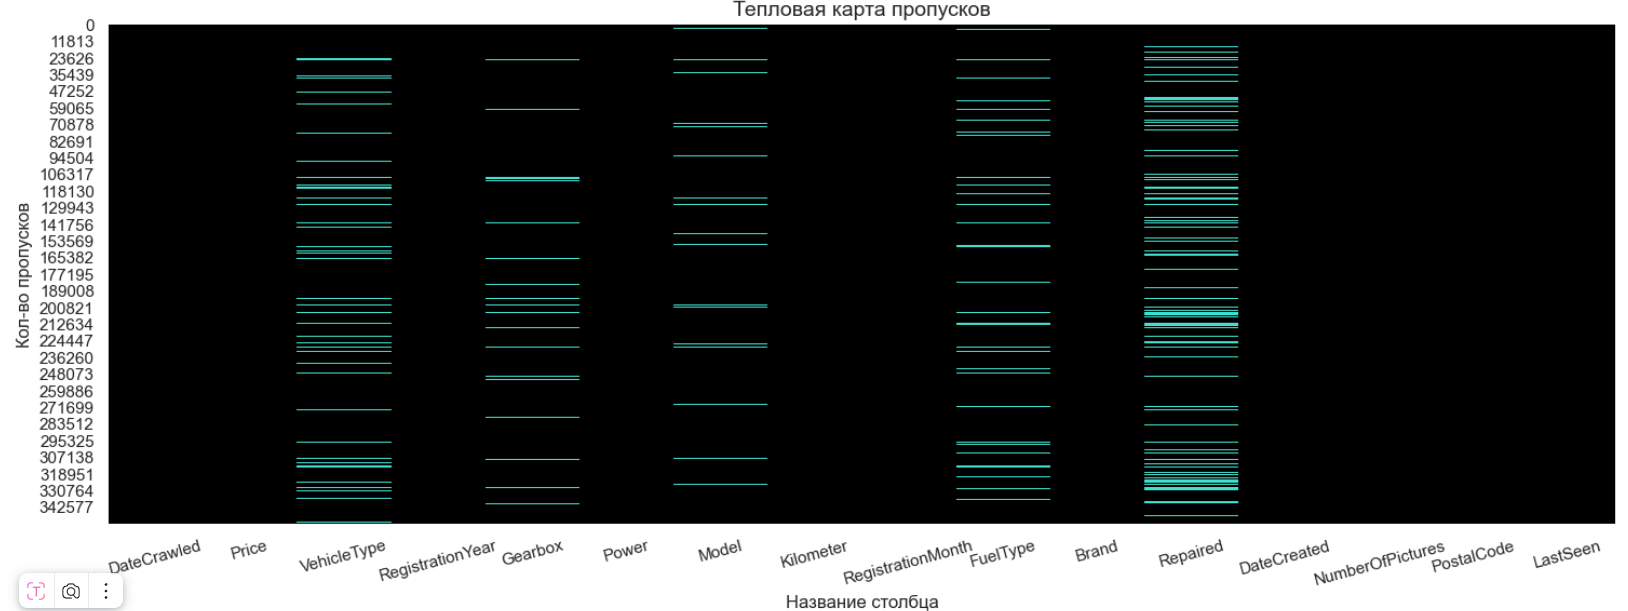

После этого мы начали исследовать данные, чтобы выявить выбросы и аномалии. Проанализировали гистограммы, чтобы оценить распределение признаков. Также изучили базовые статистические показатели. В данных оказалось много машин с очень низкой стоимостью и мощностью. Мы удалили эти аномалии, исключив машины с нулевой ценой и мощностью. Также мы ограничили максимальную мощность, поскольку машина с мощностью более 3000 — это явное отклонение от нормы. Кроме того, мы отфильтровали данные по дате регистрации, установив диапазон допустимых дат. Значения «0» для месяца регистрации были заменены на значения первого месяца. В результате фильтрации, мы удалили около 17% от всего датасета.

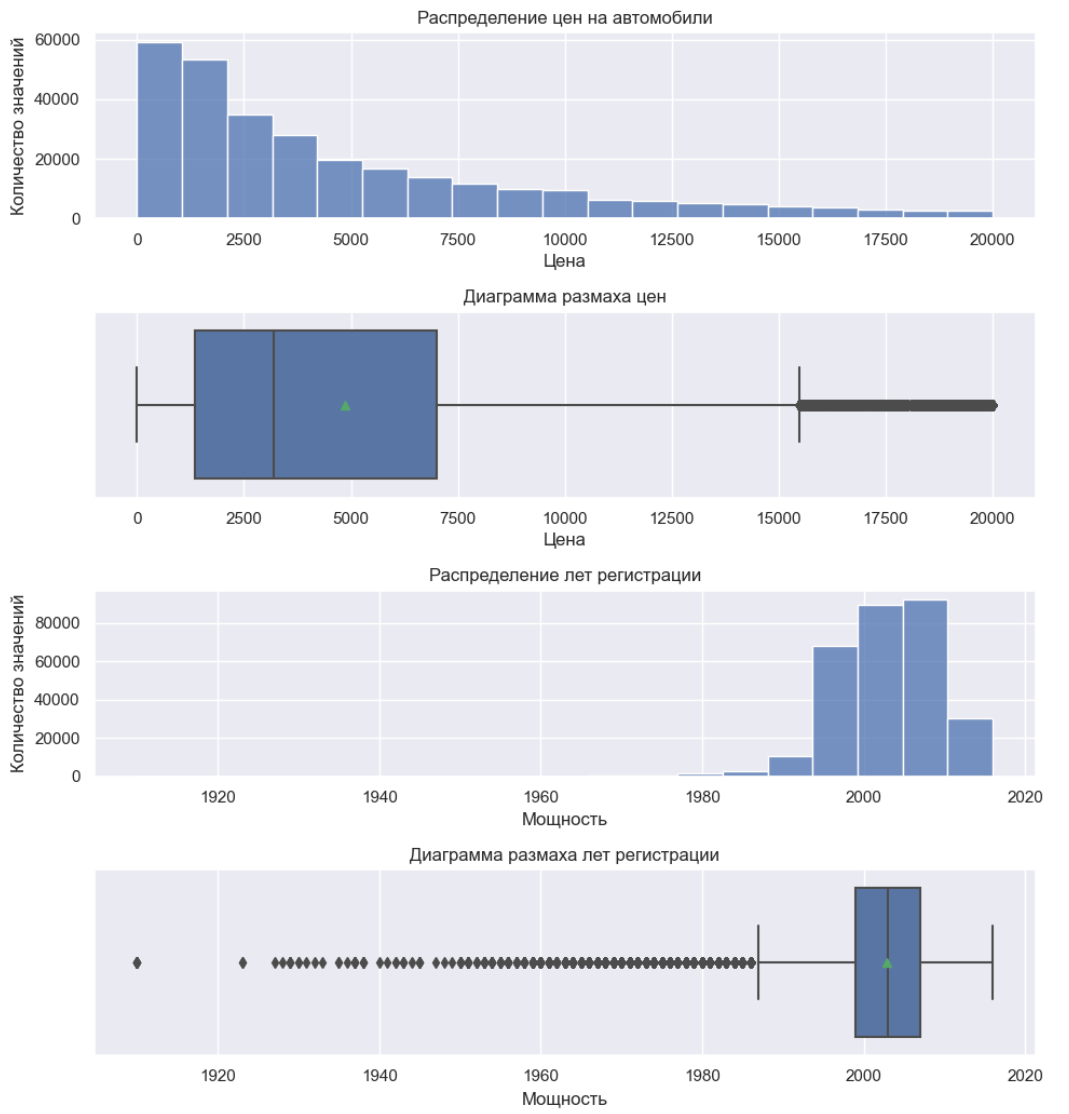

Последним шагом в этом разделе был корреляционный анализ. Заметили, что существует сильная взаимосвязь между брендом и моделью автомобиля, поэтому исключили признак, связанный с брендом, поскольку он слабо коррелировал с нашим таргетом в виде цены авто. Также заметили очень слабую корреляция между ценой автомобиля и месяцем его продажи, решили удалить этот признак из датасета. Убедились, что цена автомобиля сильно зависит от года выпуска, модели, а также от таких характеристик, как мощность, пробег и наличие ремонта.

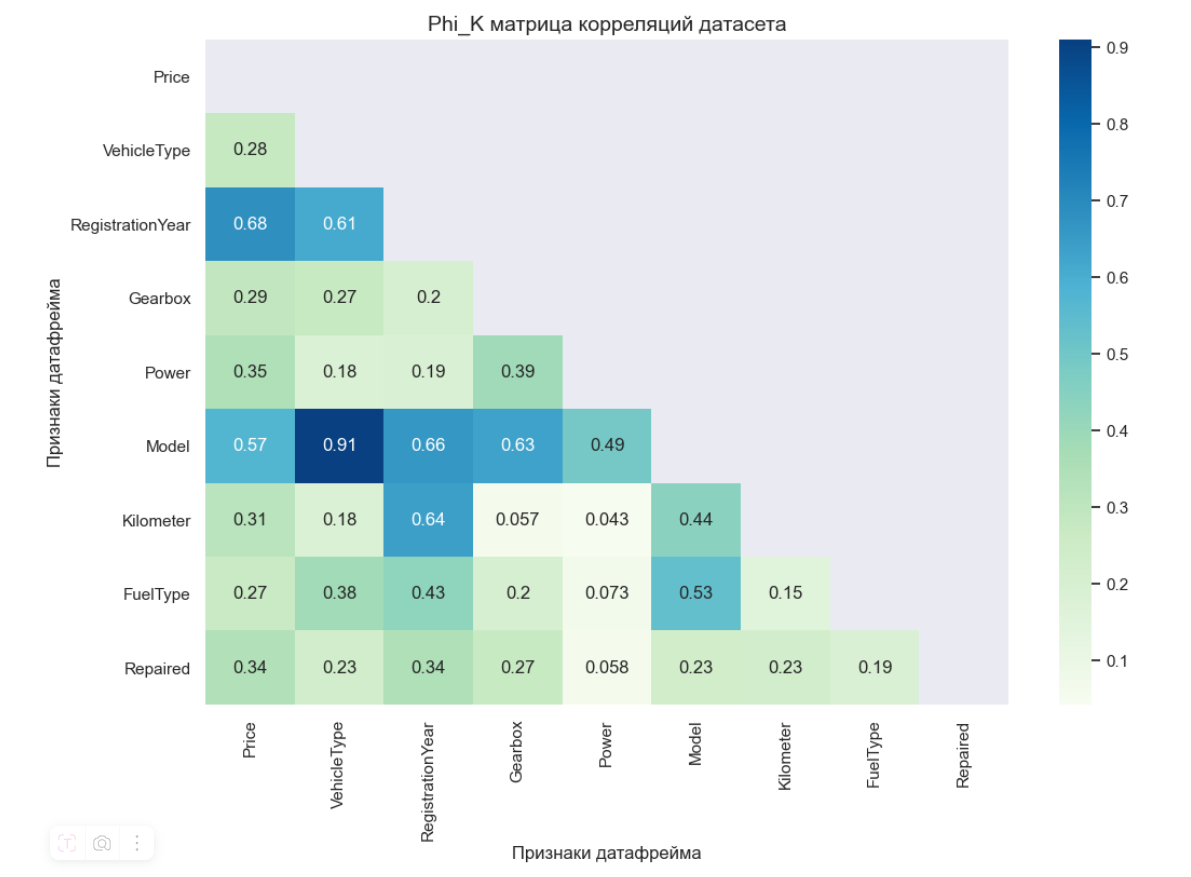

Следующим этапом было обучение моделей регрессии.
Мы разработали комплексный процесс подготовки данных, включающий два алгоритма кодирования категориальных признаков: OHE и OrdinalEncoder, и несколько методов масштабирования для числовых характеристик. В наш пайплайн были включены модели линейной регрессии и дерева решений с подобранными гиперпараметрами через GridSearch. После проверки на валидационных данных, мы измерили время обучения и предсказаний, а также рассчитали метрику RMSE.
Метрика для модели __DecisionTreeRegressor__ с глубиной дерева 15 на валидационной выборке: RMSE = __1945.589__

Затем мы перешли к обучению моделей градиентного бустинга, начав с __LightGBM__, где кодирование категориальных столбцов проводилось через LabelEncoder. Мы подобрали оптимальные гиперпараметры через GridSearch и выбрали лучшую модель, измерив время обучения и предсказания и рассчитав метрику RMSE. Метрика лучшей из моделей LightGBM с параметрами: learning_rate=0.15, max_depth=12, n_estimators=200 на валидационной выборке: __1637.161__


Завершающим этапом стало обучение модели __CatBoost__, где выбор лучшей модели также проводился через GridSearch. Метрика лучшей из моделей с параметрами: iterations=150, learning_rate=0.3, depth=12 на валидационной выборке: __1637.698__

Анализ данных показал, что лучшей моделью является __LightGBM__, демонстрирующая наилучшую метрику RMSE, а также среднее время обучения и лучшее время предсказания. 

Мы рекомендуем заказчику обратить внимание на модель __LightGBM__, которая продемонстрировала наибольшую точность и показала хорошее время работы. 

Последним этапом нашей работы стало использование лучшей модели LightGBM на тестовых данных. Метрика RMSE на тестовых данных достигла __1636.44613__, что говорит нам о том, что стоит поработать над подбором гиперпараметров для модели, а также, если точность все же важнее скорости обучения, то выбрать модель CatBoost.